# 29.10.2024: redo data cleaning because of found radiation errors

# Cosipy preparation
Prepare the data of JJMC so that it can be used as input for Cosipy. This requires the following:
- calculate air pressure from AHAB
- convert air temperature to K
- Cloud Cover: not available
- RH: in percent
- Net solar radiation: sum of outgoing and incoming
- Total precipitation: have that in data but probably not that good
- Rain: None
- wind speed
- snowfall: could compute that from difference to previous timestep?
- incoming Longwave

Have to apply several corrections!

In [1]:
#import packages
import numpy as np
import pandas as pd
import xarray as xr
import math
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import foehnix
import metpy.calc as mpcalc
from metpy.units import units

C:\Users\leopo\miniconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#read data
folder = r"C:\Users\leopo\Master\Thesis\data\data_raw"
ahab = r"\AHAB_2004-2014_cleaned_191007.xlsx"
jjmc = r"\JJMC_2004-2014_Cleaned_191007.xlsx"
foehn_data = r"\foehn_probability_shallowfoehn.xlsx"

filepath_ahab = folder+ahab
filepath_jjmc = folder+jjmc
filepath_foehn = folder+foehn_data

ahab = pd.read_excel(filepath_ahab, sheet_name = "AHAB_2004-2014_Cleaned", index_col = "Datetime", header = 2, na_values = [-3999, -5999, -6999 , -7999])
jjmc = pd.read_excel(filepath_jjmc, sheet_name = "JJMC_Table1_Cleaned", index_col = "Datetime", header = 2, na_values = [-3999, -5999, -6999 , -7999]) 
foehn = pd.read_excel(filepath_foehn, index_col = "utc_time")

### considered period and utc time
data is in Alaskan time which is 8 hours behind utc. Have to add this time offset to make it comparable with ERA5 data. <br>
focus on period after 14.08.2008 18:00 alaskan time, because this period provides the most consistent data. 17.08.2008 16:00alaskan time the wind vane was rotated so one has to include a 180° offset but this should not be important for the energy fluxes as no wind direction data is needed then

In [3]:
data_list = [ahab, jjmc]

#for loop to add utc_time column to each dataset
for data in data_list:
    data["utc_time"] = data.index  + pd.DateOffset(hours = 8)
    data["Datetime"] = data.index
    data.set_index("utc_time", inplace = True)

In [4]:
#only data from the foehn classification period
ahab = ahab.loc[(ahab.index >= foehn.index[0]) & (ahab.index < "2015")]
jjmc = jjmc.loc[(jjmc.index >= foehn.index[0]) & (jjmc.index < "2015")]

In [5]:
jjmc["Datetime"].head()

utc_time
2008-08-17 01:00:00   2008-08-16 17:00:00
2008-08-17 02:00:00   2008-08-16 18:00:00
2008-08-17 03:00:00   2008-08-16 19:00:00
2008-08-17 04:00:00   2008-08-16 20:00:00
2008-08-17 05:00:00   2008-08-16 21:00:00
Name: Datetime, dtype: datetime64[ns]

### wind direction
JJMC wind direction has to be corrected for the 180° offset

In [6]:
#wind at jjmc with 180° offset
mask = (jjmc["3m Wind dir"] > 180) & (jjmc['Datetime'] > pd.to_datetime("2008-08-17 12:00:00"))
mask2 = ((jjmc["3m Wind dir"] <= 180) & (jjmc["3m Wind dir"] > 0)) & (jjmc['Datetime'] > pd.to_datetime("2008-08-17 12:00:00"))

jjmc.loc[mask, "3m Wind dir"] -= 180
jjmc.loc[mask2, "3m Wind dir"] += 180

#remove 0 from jjmc wind data
mask = (jjmc['3m Wind dir'] == 0) | (jjmc['3m Wind (m/s)'] == 0)
jjmc.loc[mask, ['3m Wind dir', '3m Wind (m/s)']] = np.nan

### air temperature
- temperatures above 20 or below -50 °C are removed
- remove the temperature at the timesteps when the value of the temperature difference to the previous timestep is larger or smaller than 10

In [7]:
jjmc["2m AT (K)"] = jjmc["AT 2m"] + 273.15

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2267546589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["2m AT (K)"] = jjmc["AT 2m"] + 273.15


In [17]:
#delete unreasonable high or low 2m temperatures
#jjmc
jjmc.loc[(jjmc["AT 2m"] > 20) | (jjmc["AT 2m"] < -49), "AT 2m"] = np.nan

#ahab
ahab.loc[(ahab["3m AT ( C)"] > 20) | (ahab["3m AT ( C)"] < -50), "3m AT ( C)"] = np.nan


In [18]:
#Tdiff
#JJMC
jjmc["T_diff"] = jjmc["AT 2m"].diff()
#AHAB
ahab["T_diff"] = ahab["3m AT ( C)"].diff()

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3202052558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["T_diff"] = jjmc["AT 2m"].diff()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3202052558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahab["T_diff"] = ahab["3m AT ( C)"].diff()


In [10]:
ahab["3m AT ( C)"].nlargest(20)

utc_time
2011-06-27 01:00:00    16.08
2011-06-27 00:00:00    15.58
2011-06-27 02:00:00    15.35
2013-06-19 23:00:00    14.72
2013-06-20 00:00:00    14.70
2013-06-20 02:00:00    14.68
2013-06-27 02:00:00    14.66
2013-06-19 00:00:00    14.52
2013-06-20 01:00:00    14.51
2013-06-19 01:00:00    14.44
2011-06-27 03:00:00    14.32
2013-06-20 22:00:00    14.19
2013-07-15 02:00:00    14.19
2013-06-21 01:00:00    14.05
2009-08-01 00:00:00    13.95
2013-06-20 03:00:00    13.93
2011-06-27 23:00:00    13.92
2013-07-15 01:00:00    13.92
2009-07-31 23:00:00    13.85
2013-06-27 01:00:00    13.82
Name: 3m AT ( C), dtype: float64

In [15]:
ahab[["3m AT ( C)", "T_diff"]]["2013-03-05 15:00:00":"2013-03-06 05:00:00"]

,3m AT ( C),T_diff
utc_time,,
2013-03-05 15:00:00,-13.57,-0.24
2013-03-05 16:00:00,-13.91,-0.34
2013-03-05 17:00:00,-13.43,0.48
2013-03-05 18:00:00,-13.19,0.24
2013-03-05 19:00:00,-12.82,0.37
2013-03-05 20:00:00,-11.94,0.88
2013-03-05 21:00:00,0.00,11.94
2013-03-05 22:00:00,-8.69,-8.69
2013-03-05 23:00:00,-11.56,-2.87


In [15]:
ahab["T_diff"].nsmallest(20)

utc_time
2012-01-03 22:00:00   -21.620
2013-03-11 22:00:00   -18.350
2013-03-12 22:00:00   -17.060
2013-03-13 22:00:00   -16.860
2011-12-21 21:00:00   -15.930
2013-03-04 23:00:00   -13.640
2013-03-03 22:00:00   -12.560
2013-03-02 22:00:00   -10.980
2013-03-01 22:00:00   -10.420
2013-03-06 22:00:00   -10.060
2012-01-14 22:00:00    -8.730
2013-03-05 22:00:00    -8.690
2009-10-18 01:00:00    -8.149
2013-03-07 22:00:00    -8.030
2012-01-03 23:00:00    -6.950
2014-08-02 06:00:00    -6.565
2013-02-28 23:00:00    -6.405
2013-03-13 23:00:00    -6.400
2012-08-19 01:00:00    -5.935
2010-10-06 23:00:00    -5.826
Name: T_diff, dtype: float64

In [19]:
#unreasonably high temperature differences
#jjmc
jjmc.loc[np.abs(jjmc["T_diff"]) >= 10, ["AT 2m", "T_diff"]] = np.nan
#ahab
ahab.loc[np.abs(ahab["T_diff"]) >= 10, ["3m AT ( C)", "T_diff"]] = np.nan

## air pressure
use approximation of barometric height formula for the calculation of air pressure at JJMC derived from the measured pressure at AHAB <br>
Corrections:
pressure at AHAB only considered between 850 and 650 hPa. Max in data is 793 hPa, min which seems still reasonable is 710.<br>
For JJMC this means that the calculated pressure is between 774.9 and 865.5 hPa, which seems reasonable. Values with the more accurate barometric height formula as used in cosipy are similar if the standard atmospheric lapse rate of 0.0065 K/m is used. One has to consider that the real lapse rates are often deviating due to the glacier boundary layer.

In [17]:
#alternative: more accurate (?) barometric height formula as used in cosipy
# works with lapse rates between stations, height difference temperature of jjmc + constant exponent
testp_jjmc2 = ahab["pressure (mb)"].values / np.power((1 - (0.003 * 700) / (jjmc["AT 2m"]+273.15)), 5.255)

In [20]:
#heights
h_ahab, h_jjmc, h_term = (2414, 1714, 1331) #m
d_alt_ahab_jjmc = h_ahab - h_jjmc
scale_height = 8000 #m
lapse_rate_ahab_jjmc = (jjmc["AT 2m"] - ahab["3m AT ( C)"]) / 700

#calculate air pressure at a station depending on its height
def barometric_height(ahab, h_station):
    ahab["pressure (mb)"] = ahab["pressure (mb)"].apply(lambda x : np.nan if (x > 850 or x < 650) else x)
    p_air = ahab["pressure (mb)"].values * np.exp((h_ahab - h_station) / scale_height)
    return p_air

def barometric_height_cos(lower_station, lapse_rate, t_var, d_alt):
    p_air = ahab["pressure (mb)"].values / np.power((1 - (0.0065 * d_alt) / (lower_station[t_var]+273.15)), 5.255)
    return p_air
    
jjmc["pressure (mb)"] = barometric_height(ahab, h_jjmc)
jjmc["pressure cos"] = barometric_height_cos(jjmc, lapse_rate_ahab_jjmc, "AT 2m", 700)

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\955351208.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ahab["pressure (mb)"] = ahab["pressure (mb)"].apply(lambda x : np.nan if (x > 850 or x < 650) else x)
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\955351208.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["pressure (mb)"] = barometric_height(ahab, h_jjmc)
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\955351208.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [12]:
jjmc["pressure (mb)"].nlargest(20)

utc_time
2010-07-08 19:00:00    865.513716
2010-07-08 20:00:00    865.513716
2010-07-08 18:00:00    861.147947
2010-07-08 09:00:00    854.599293
2010-07-08 10:00:00    854.599293
2010-07-08 11:00:00    852.416409
2010-07-08 12:00:00    852.416409
2010-07-08 16:00:00    852.416409
2010-07-08 15:00:00    851.324966
2010-07-24 22:00:00    851.324966
2010-07-08 13:00:00    850.233524
2010-07-08 14:00:00    850.233524
2010-07-08 17:00:00    846.959197
2009-07-02 14:00:00    842.593428
2009-07-02 15:00:00    842.593428
2009-07-02 16:00:00    842.593428
2009-07-02 17:00:00    842.593428
2009-07-02 18:00:00    842.593428
2009-07-02 19:00:00    842.593428
2009-07-02 20:00:00    842.593428
Name: pressure (mb), dtype: float64

### relative humidity 
in percent, check for wrong values --> exclude everything above 100 and below 0

### radiation corrections:
SW: np.nan if > 1600 or smaller -5; 0 if larger -5 but smaller 0
LW: np.nan if smaller/larger than radiation calculated by Stefan Boltzmann with min or maximum air temperature and surface emission coefficient of 0.99

##### net solar radiation
need net solar radiation = SWin-SWout

In [ ]:
jjmc["CG3 down cal"].min()

jjmc["CG3 down cal"].min()

In [17]:
sigma = 5.67e-08
sigma * 0.99 * np.power(293.15, 4)

414.55088589946274

In [26]:
#corrections for radiation 
sigma = 5.67e-08 # W/(m^2 K^4) Boltzmann constant
sfc_e_coeff = 0.99
#new corrections
#SW in and out
#to np.nan for significant errors
jjmc.loc[(-5 > jjmc["CM3 up Cal"]) | (1600 < jjmc["CM3 up Cal"]), ["CM3 up Cal"]] = np.nan
jjmc.loc[(-5 > jjmc["CM3 Down Cal"]) | (1600 < jjmc["CM3 Down Cal"]), ["CM3 Down Cal"]] = np.nan

jjmc.loc[(-5 < jjmc["CM3 up Cal"]) & (0 > jjmc["CM3 up Cal"]), ["CM3 up Cal"]] = 0
jjmc.loc[(-5 < jjmc["CM3 Down Cal"]) & (0 > jjmc["CM3 Down Cal"]), ["CM3 Down Cal"]] = 0
#jjmc[["CM3 Down Cal", "CM3 up Cal"]] = jjmc[["CM3 Down Cal", "CM3 up Cal"]].applymap(lambda x: np.nan if (x > 1370 or x < -5) else x)
#to 0 for small negative during night
#jjmc[["CM3 Down Cal", "CM3 up Cal"]] = jjmc[["CM3 Down Cal", "CM3 up Cal"]].applymap(lambda x: 0 if (x > -5 and x < 0) else x)
#SWin cannot be smaller than SWout
jjmc.loc[jjmc["CM3 Down Cal"] > jjmc["CM3 up Cal"], ["CM3 Down Cal", "CM3 up Cal"]] = np.nan

#LWin and out
#corrections matching min and max temperature boundaries (=-50 and 20 °C), for LW_out: max is =°C, melting temperature
LW_out_min = sigma * sfc_e_coeff * np.power(223.15, 4)
LW_out_max = sigma * sfc_e_coeff * np.power(293.15, 4)
LW_in_min = sigma * np.power(223.15, 4)
LW_in_max = sigma * np.power(293.15, 4)

#LWout
jjmc["CG3 down cal"] = jjmc[["CG3 down cal"]].applymap(lambda x: np.nan if (x < LW_out_min or x > LW_out_max) else x)

#LWin
jjmc["CG3 up cal"] = jjmc[["CG3 up cal"]].applymap(lambda x: np.nan if (x < LW_in_min or x > LW_in_max) else x)


C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2785607122.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["CG3 down cal"] = jjmc[["CG3 down cal"]].applymap(lambda x: np.nan if (x < LW_out_min or x > LW_out_max) else x)
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2785607122.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["CG3 up cal"] = jjmc[["CG3 up cal"]].applymap(lambda x: np.nan if (x < LW_in_min or x > LW_in_max) else x)


In [38]:
for s in ["CG3 up cal", "CG3 down cal", "CM3 Down Cal", "CM3 up Cal"]:
    print("max: ", jjmc[s].max(), "min: ", jjmc[s].min())

max:  387.56315007666655 min:  140.60260269813065
max:  335.1722284972811 min:  152.74455316626833
max:  706.9589001861665 min:  0.0
max:  967.734784476586 min:  0.0


In [39]:
jjmc["SW_net"] = jjmc["CM3 up Cal"] - jjmc["CM3 Down Cal"]

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\459404427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SW_net"] = jjmc["CM3 up Cal"] - jjmc["CM3 Down Cal"]


In [40]:
jjmc.loc[jjmc["SW_net"] < 0]

,Unnamed: 0,Year,Day,Time,batt volt,log temp,AT 3m,RH 3m,AT 2m,RH 2m,...,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Datetime,2m AT (K),T_diff,pressure (mb),pressure cos,SW_net
utc_time,,,,,,,,,,,,,,,,,,,,,


### Albedo

use daily Albedo:
$\frac{daily sumSW_{out}}{daily sum SW_{in}}$ <br>
in months with too less solar radiation I just use a constant value of 0.85

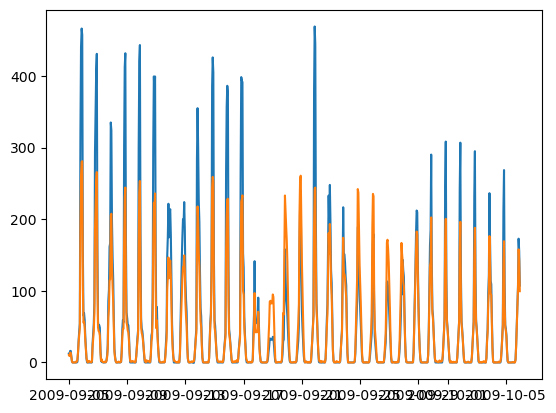

In [27]:
start = "2009-09-05"
end = "2009-10-05"
plt.plot(jjmc['CM3 up Cal'][start:end])
plt.plot(jjmc["CM3 Down Cal"][start:end])

In [44]:
#if one of incoming or outgoing is 0 or np.nan the other one also hast to
#jjmc["SWin_cor"] = np.where(jjmc['CM3 up Cal'].isnull() | (jjmc['CM3 up Cal'] == 0) | jjmc['CM3 Down Cal'].isnull() | (jjmc['CM3 Down Cal']), 0, jjmc['CM3 up Cal'])
#jjmc["SWout_cor"] = np.where(jjmc['CM3 up Cal'].isnull() | (jjmc['CM3 up Cal'] == 0) | jjmc['CM3 Down Cal'].isnull() | (jjmc['CM3 Down Cal']), 0, jjmc['CM3 Down Cal'])

#SW_in = jjmc['CM3 up Cal']
#SW_out = jjmc['CM3 Down Cal']

#jjmc["SWin_cor"] = np.where(jjmc["CM3 up Cal"] > jjmc["


daily_sums_SWin = jjmc.groupby(pd.Grouper(freq='D'))['CM3 up Cal'].transform('sum')
daily_sums_SWout = jjmc.groupby(pd.Grouper(freq='D'))['CM3 Down Cal'].transform('sum')
jjmc["daily_albedo"] = daily_sums_SWout / daily_sums_SWin

#jjmc["daily_albedo"] = np.where(jjmc["daily_albedo"] >= 1, 0.85, jjmc["daily_albedo"])

#jjmc["daily_albedo"] = np.where(jjmc["CM3 up Cal"] >= jjmc["CM3 Down Cal"], jjmc["daily_albedo"], np.nan)

#replace polar night with 0.85
jjmc.loc[(jjmc.index.month >= 11) | (jjmc.index.month <= 2), "daily_albedo"] = 0.85

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\699585582.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["daily_albedo"] = daily_sums_SWout / daily_sums_SWin


In [45]:
jjmc["daily_albedo"][jjmc["daily_albedo"] >= 1]

Series([], Name: daily_albedo, dtype: float64)

In [29]:
jjmc.index.day.max()

31

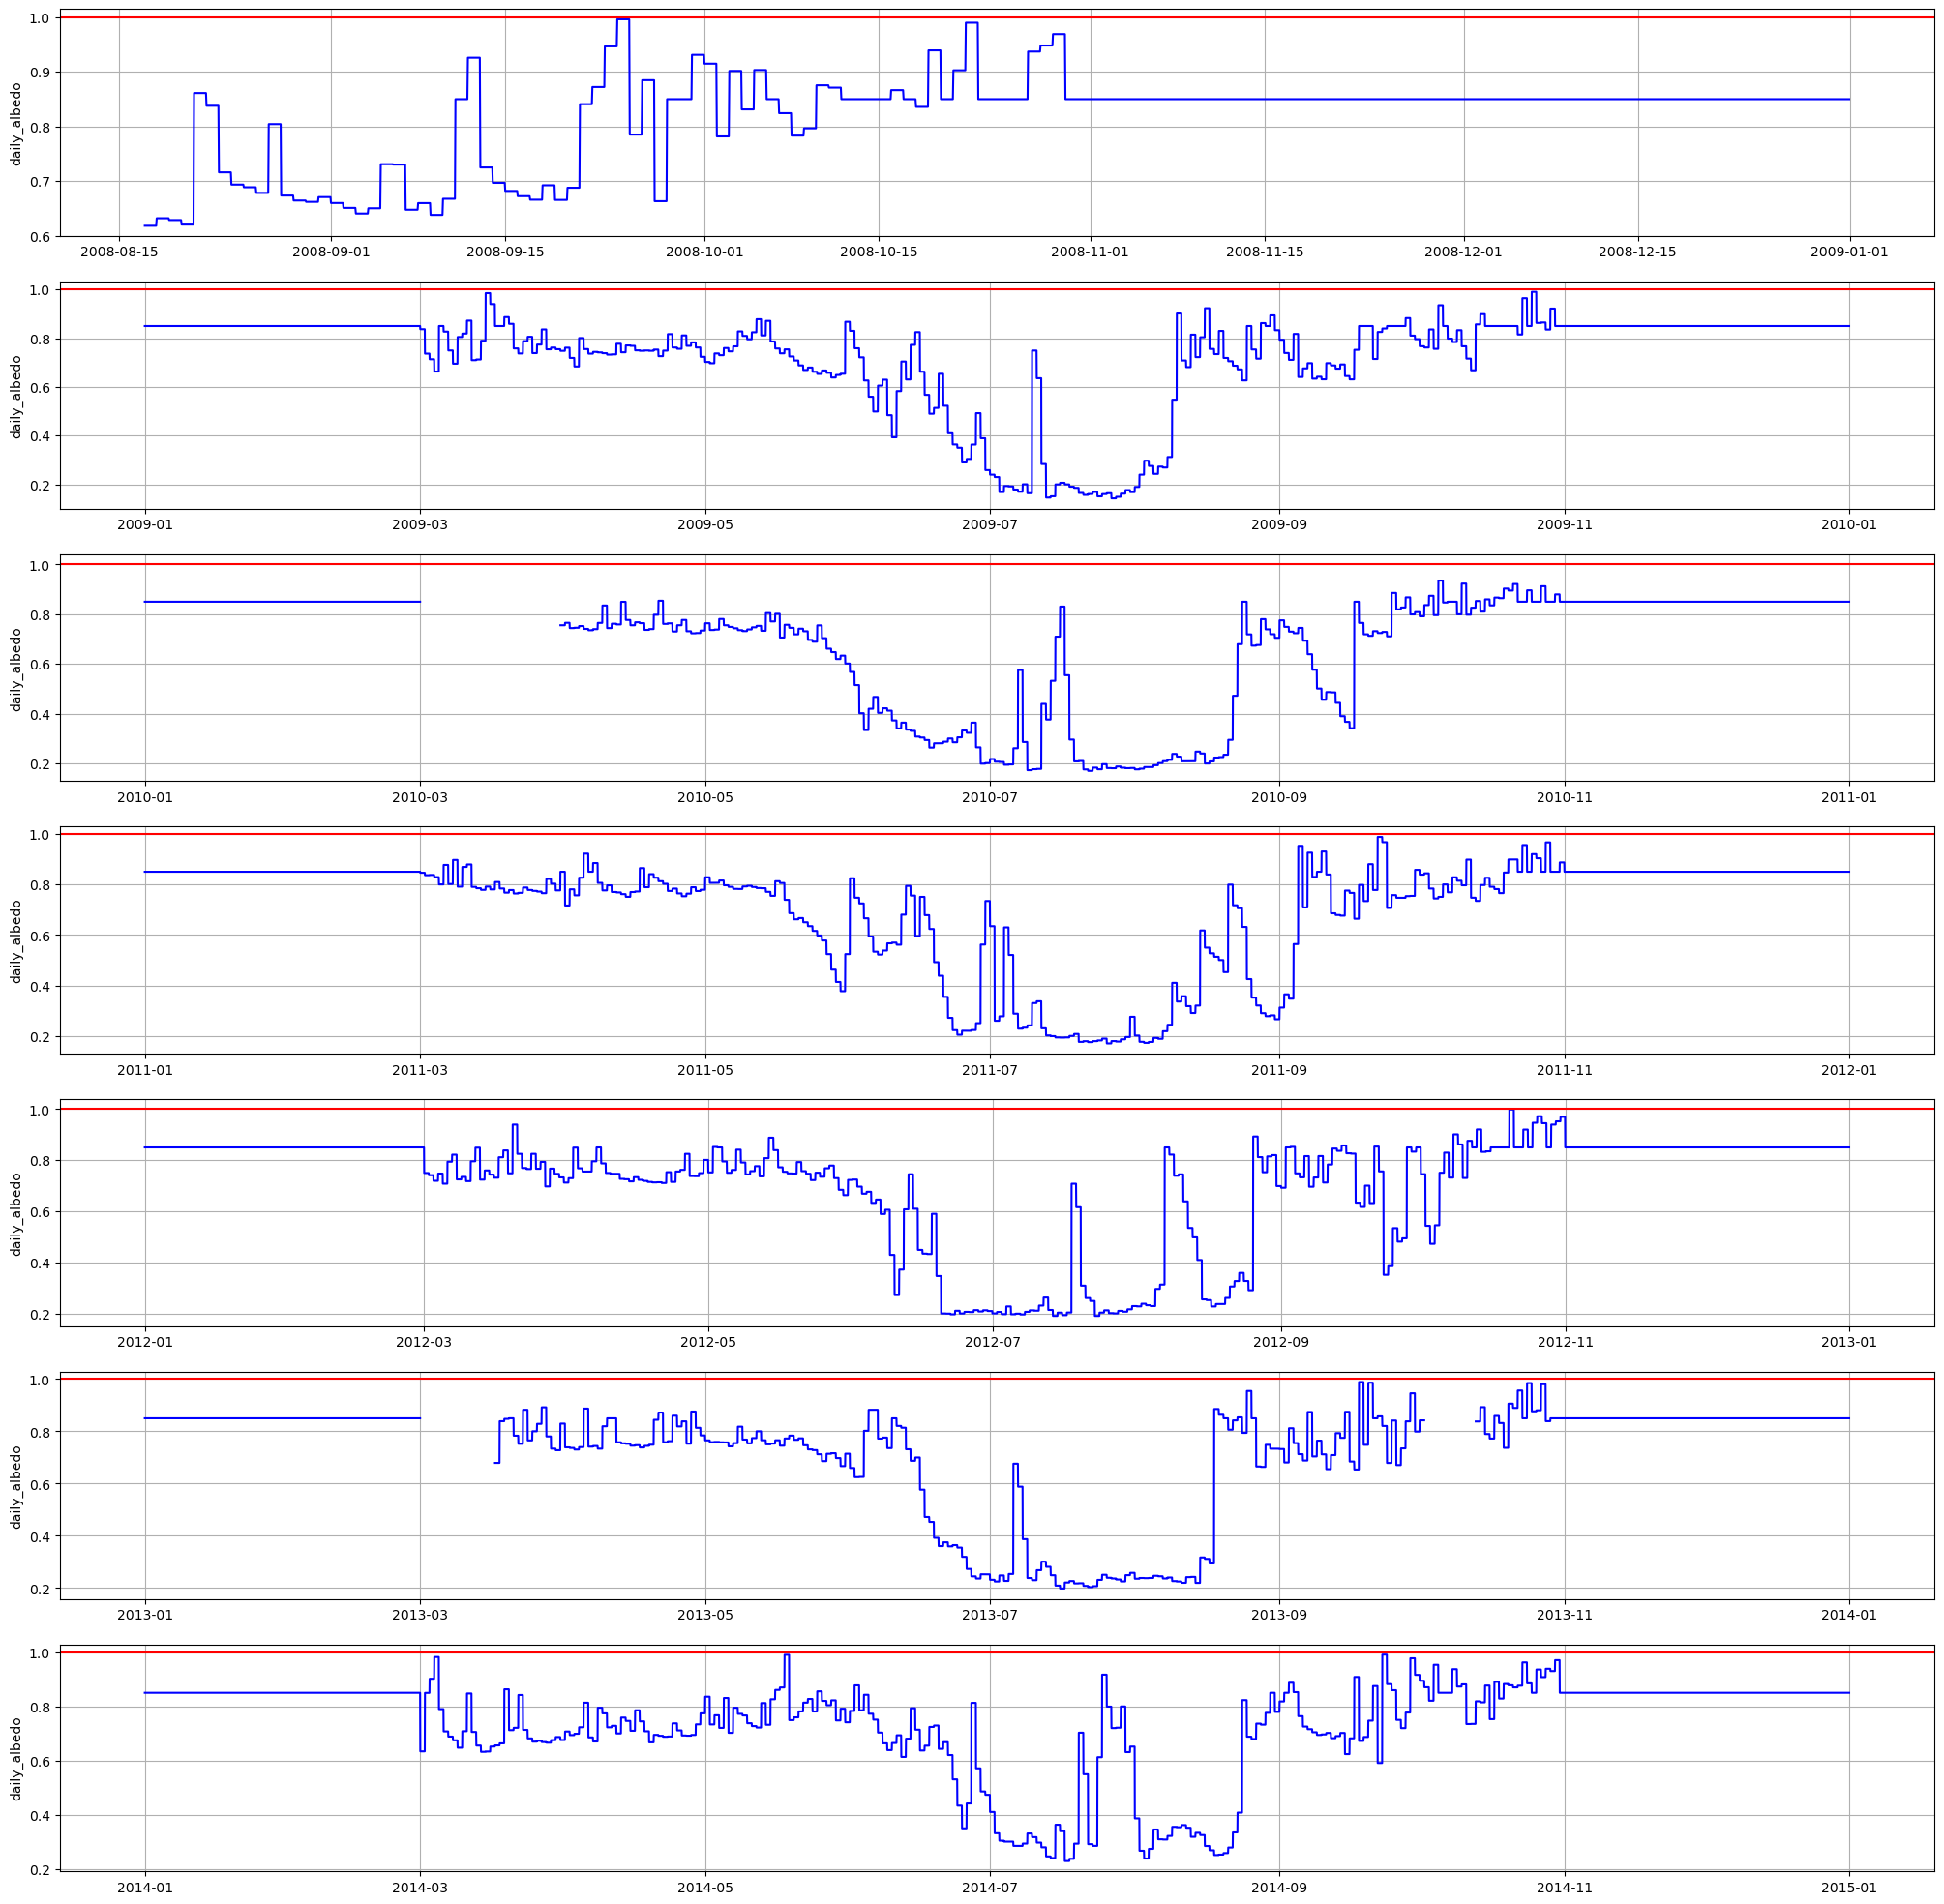

In [30]:
years = np.arange(2008, 2015)
fig = plt.figure(figsize = (25,25))
for i,year in enumerate(years):
    #sr50
    ax = fig.add_subplot(len(years),1,i+1)
    #distance to snow sfc
    ax.plot(jjmc['daily_albedo'][f"{year}"], label = "jjmc", color = "b")
    ax.axhline(1, color = "red")
    ax.set_ylabel("daily_albedo")
    ax.grid()
   

### Total precipitation/Snowfall
At JJMC one tipping bucket was present for liquid presentation, snowfall has to be estimated by the sonic ranger data. <br>
corrections: 
- below 0.85 (evaluated just by looking at timeseries) is error value or possibly a ice/snow covered sensor --> remove that
- remove SR50 data where difference to previous hour is larger than 0.2 m / smaller -0.2 
- divide data into the parts without major datagaps, where i can interpolate over small gaps and have more complete data

Afterwards I can compute running means of the SR50 data, e.g. with windows of 12, 24, 36 or 48 (hours) as in the SR50_GAM notebook. These running means are free from the noise of the raw SR50 data and represent the real trend of the snow thickness better. I can than get snowfall events by calculating the difference between the running means of the SR50 data. A negative change towards the next timestep means that the distanc to the snow surface decreased, which means snowfall. <br>
<br>

I can than use the computed snowfall together with the rain data to get the total precipitation. I do that in the following way:
- snowfall = -1 * difference of SR50 runmean
- If T > 0 use rain measurement, if not use SR50 - snowfall for total precipitation

##### cosipy:
cosipy already throws a warning message if snowfall > 0.05 m and RRR > 25mm

In [46]:
#remove obvious error values
for data in [jjmc]:
    data.loc[data["SR50 cor"] <= 0.85, "SR50 cor"] = np.nan

#calculate SR50 diff and exclude events where np.abs of difference >= 0.2
for data in [jjmc]:
    data["SR50_diff"] = data["SR50 cor"].diff()
    data.loc[(data["SR50_diff"] >= 0.2) | (data["SR50_diff"] <= -0.2), ["SR50_diff", "SR50 cor"]] = np.nan

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2943406391.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SR50_diff"] = data["SR50 cor"].diff()


In [47]:
pd.to_datetime("2008-08-17") - pd.DateOffset(hours = 7)

Timestamp('2008-08-16 17:00:00')

In [49]:
jjmc["Datetime"]

utc_time
2008-08-17 01:00:00   2008-08-16 17:00:00
2008-08-17 02:00:00   2008-08-16 18:00:00
2008-08-17 03:00:00   2008-08-16 19:00:00
2008-08-17 04:00:00   2008-08-16 20:00:00
2008-08-17 05:00:00   2008-08-16 21:00:00
                              ...        
2014-12-31 19:00:00   2014-12-31 11:00:00
2014-12-31 20:00:00   2014-12-31 12:00:00
2014-12-31 21:00:00   2014-12-31 13:00:00
2014-12-31 22:00:00   2014-12-31 14:00:00
2014-12-31 23:00:00   2014-12-31 15:00:00
Name: Datetime, Length: 55871, dtype: datetime64[ns]

In [50]:
#divide data

jjmc1 = jjmc[(jjmc["Datetime"]>=pd.to_datetime("2008-08-17")- pd.DateOffset(hours = 7)) & (jjmc["Datetime"] <= pd.to_datetime("2009-07-12"))]
jjmc2 = jjmc[(jjmc["Datetime"]>=pd.to_datetime("2009-08-12")- pd.DateOffset(hours = 7)) & (jjmc["Datetime"] <= pd.to_datetime("2009-11-25"))]
jjmc3 = jjmc[(jjmc["Datetime"]>=pd.to_datetime("2010-04-01")- pd.DateOffset(hours = 7)) & (jjmc["Datetime"] <= pd.to_datetime("2012-12-29"))]
jjmc4 = jjmc[(jjmc["Datetime"]>=pd.to_datetime("2013-03-18")- pd.DateOffset(hours = 7)) & (jjmc["Datetime"] <= pd.to_datetime("2014-12-24"))]

In [51]:
#jjmc1
jjmc1["SR50_timeseries"] = jjmc1["SR50 cor"].copy()
jjmc2["SR50_timeseries"] = jjmc2["SR50 cor"].copy()


#jjmc3
cor1 = 1.675
cor2 = 2.171
cor3 = 0.708
cor4 = 1.524

jjmc3["SR50_timeseries"] = jjmc3["SR50 cor"].copy()
jjmc3.loc[jjmc3["Datetime"]>=pd.to_datetime("2010-08-14 17:00"), "SR50_timeseries"] += cor1
jjmc3.loc[jjmc3["Datetime"]>=pd.to_datetime("2011-08-07 17:00"), "SR50_timeseries"] += cor2
jjmc3.loc[jjmc3["Datetime"]>=pd.to_datetime("2012-05-16 10:00"), "SR50_timeseries"] += cor3
jjmc3.loc[jjmc3["Datetime"]>=pd.to_datetime("2012-08-18 10:00"), "SR50_timeseries"] += cor4

#jjmc4
cor1 = 2.017
cor2 = 1.075

jjmc4["SR50_timeseries"] = jjmc4["SR50 cor"].copy()
jjmc4.loc[jjmc4["Datetime"]>=pd.to_datetime("2013-08-09 14:00"), "SR50_timeseries"] += cor1
jjmc4.loc[jjmc4["Datetime"]>=pd.to_datetime("2014-08-14 13:00"), "SR50_timeseries"] += cor2


C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2783576823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc1["SR50_timeseries"] = jjmc1["SR50 cor"].copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2783576823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc2["SR50_timeseries"] = jjmc2["SR50 cor"].copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2783576823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [52]:
#interpolate to fill small data gaps
for data in [jjmc1,jjmc2, jjmc3, jjmc4]:
    data["SR50_timeseries"] = data["SR50_timeseries"].interpolate(method='linear')

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2469918055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SR50_timeseries"] = data["SR50_timeseries"].interpolate(method='linear')


In [53]:
#calculate running means
for data in [jjmc1, jjmc2, jjmc3, jjmc4]:
    data["SR50_runmean5"] = data["SR50_timeseries"].rolling(window=5, center = True).mean()
    data["SR50_runmean10"] = data["SR50_timeseries"].rolling(window=10, center = True).mean()
    data["SR50_runmean12"] = data["SR50_timeseries"].rolling(window=12, center = True).mean()
    data["SR50_runmean15"] = data["SR50_timeseries"].rolling(window=15, center = True).mean()
    data["SR50_runmean24"] = data["SR50_timeseries"].rolling(window=24, center = True).mean()
    data["SR50_runmean36"] = data["SR50_timeseries"].rolling(window=36, center = True).mean()
    data["SR50_runmean48"] = data["SR50_timeseries"].rolling(window=48, center = True).mean()
    data["SR50_runmean60"] = data["SR50_timeseries"].rolling(window=60, center = True).mean()
    data["SR50_runmean72"] = data["SR50_timeseries"].rolling(window=72, center = True).mean()
    data["SR50_runmean84"] = data["SR50_timeseries"].rolling(window=84, center = True).mean()
    data["SR50_runmean96"] = data["SR50_timeseries"].rolling(window=96, center = True).mean()
    data["SR50_runmean108"] = data["SR50_timeseries"].rolling(window=108, center = True).mean()
    data["SR50_runmean120"] = data["SR50_timeseries"].rolling(window=120, center = True).mean()
    data["SR50_runmean168"] = data["SR50_timeseries"].rolling(window=168, center = True).mean()

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3607844705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SR50_runmean5"] = data["SR50_timeseries"].rolling(window=5, center = True).mean()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3607844705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SR50_runmean10"] = data["SR50_timeseries"].rolling(window=10, center = True).mean()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3607844705.py:5: SettingWithCopyWarning: 
A value is tryin

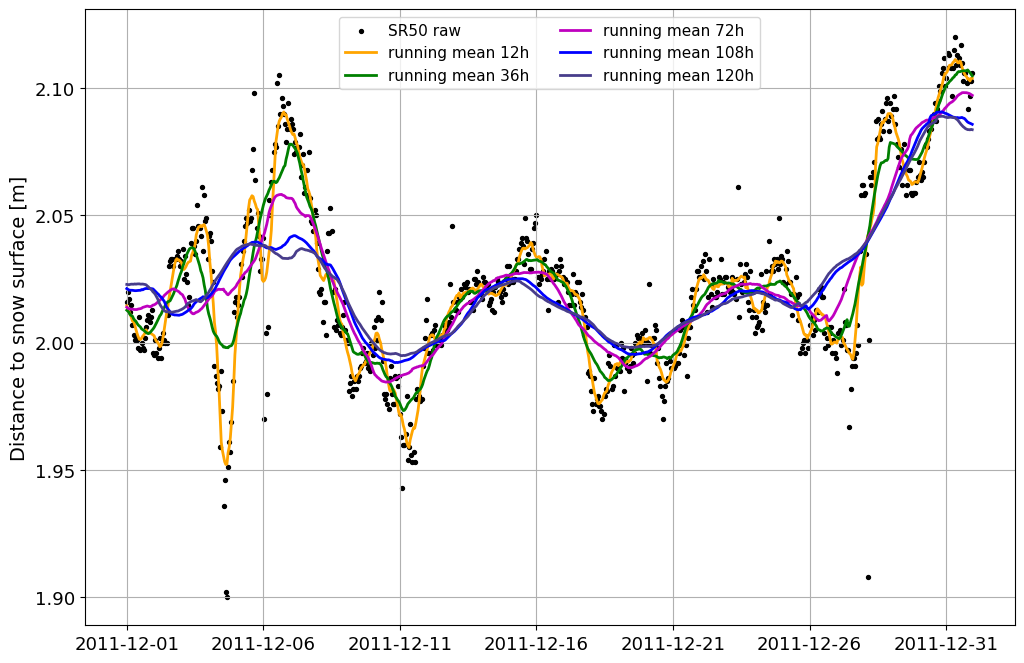

In [54]:
start = "2011-12-01"
end = "2011-12-31"
cor1 = 1.675
cor2 = 2.171

#label and tick font
plt.rcParams['axes.labelsize'] = 14  # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 13  # fontsize of the x ticks
plt.rcParams['ytick.labelsize'] = 13  # fontsize of the y ticks
plt.rcParams['legend.fontsize'] = 11  # fontsize of the legend
plt.rcParams['axes.titlesize'] = 16   # fontsize of the subplot titles

#plot GAM splines without intercept explicitly added
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(jjmc3[start:end].index, jjmc3["SR50_timeseries"][start:end] - cor1 - cor2, color='k', s = 8, label='SR50 raw')

#add GAM
#ax.plot(x[0:364], fitG.predict(x)[0:364], color= "b", label = "GAM with 20 splines")
#ax.plot(jjmc[start:end].index, jjmc["fit_100"][start:end], color= "green", linewidth = 2, label = "GAM 100 splines")
#ax.plot(jjmc[start:end].index, jjmc["fit_300"][start:end], color= "magenta", linewidth = 2, label = "GAM 300 splines")
#ax.plot(jjmc[start:end].index, jjmc["fit_500"][start:end], color= "b", linewidth = 2, label = "GAM 500 splines")
#ax.plot(jjmc[start:end].index, jjmc["fit_1000"][start:end], color= "orange", linewidth = 2, label = "GAM 1000 splines")

#add running means
#ax.plot(jjmc[start:end].index, jjmc["SR50_runmean5"][start:end], color= "b", linewidth = 2, label = "running mean 5")
#ax.plot(jjmc[start:end].index, jjmc["SR50_runmean10"][start:end], color= "r", linewidth = 2, label = "running mean 10")
ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean12"][start:end]- cor1 - cor2, color= "orange", linewidth = 2, label = "running mean 12h")
ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean36"][start:end]- cor1 - cor2, color= "green", linewidth = 2, label = "running mean 36h")
#ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean24"][start:end], color= "yellow", linewidth = 2, label = "running mean 24")
#ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean36"][start:end], color= "orange", linewidth = 2, label = "running mean 36")

#ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean60"][start:end], color= "r", linewidth = 2, label = "running mean 60")
ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean72"][start:end]- cor1 - cor2, color= "m", linewidth = 2, label = "running mean 72h")
ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean108"][start:end]- cor1 - cor2, color= "b", linewidth = 2, label = "running mean 108h")
ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean120"][start:end]- cor1 - cor2, color= "darkslateblue", linewidth = 2, label = "running mean 120h")
#ax.plot(jjmc3[start:end].index, jjmc3["SR50_runmean168"][start:end], color= "magenta", linewidth = 2, label = "running mean 168")
#ax.plot(x[0:364], fit_between.predict(x)[0:364], color= "g", label = "GAM with 15 splines")

#daily means
#ax.plot(jjmc[start:end].index, jjmc["SR50_dailymean"][start:end], color= "magenta", linewidth = 2, label = "daily mean")

#ax.set_xlabel('Day of Year')
# Festlegen der xticks auf einen 5-Tages-Abstand
ax.set_xticks(pd.date_range(start=start, end=end, freq='5D'))

# Formatieren der xticklabels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Distance to snow surface [m]')
ax.grid()


ax.legend(loc = "upper center", ncol=2)
plt.show()
#plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_precipitation\jjmc_precip_calculation\runmean_comparison.pdf", bbox_inches = "tight")
#plt.close()

In [55]:
#compute snowfalls
for data in [jjmc1, jjmc2, jjmc3, jjmc4]:
    
    data["SR_runmean12_diff"] = data["SR50_runmean12"].diff()
    data["12mean_snowfall"] = np.where(data["SR_runmean12_diff"] < 0, data["SR_runmean12_diff"], 0) * (-1)
    
    data["SR_runmean24_diff"] = data["SR50_runmean24"].diff()
    data["24mean_snowfall"] = np.where(data["SR_runmean24_diff"] < 0, data["SR_runmean24_diff"], 0) * (-1)

    data["SR_runmean36_diff"] = data["SR50_runmean36"].diff()
    data["36mean_snowfall"] = np.where(data["SR_runmean36_diff"] < 0, data["SR_runmean36_diff"], 0) * (-1)

    data["SR_runmean48_diff"] = data["SR50_runmean48"].diff()
    data["48mean_snowfall"] = np.where(data["SR_runmean48_diff"] < 0, data["SR_runmean48_diff"], 0) * (-1)

    data["SR_runmean60_diff"] = data["SR50_runmean60"].diff()
    data["60mean_snowfall"] = np.where(data["SR_runmean60_diff"] < 0, data["SR_runmean60_diff"], 0) * (-1)

    data["SR_runmean72_diff"] = data["SR50_runmean72"].diff()
    data["72mean_snowfall"] = np.where(data["SR_runmean72_diff"] < 0, data["SR_runmean72_diff"], 0) * (-1)
    
    data["SR_runmean108_diff"] = data["SR50_runmean108"].diff()
    data["108mean_snowfall"] = np.where(data["SR_runmean108_diff"] < 0, data["SR_runmean108_diff"], 0) * (-1)
    
    data["SR_runmean120_diff"] = data["SR50_runmean120"].diff()
    data["120mean_snowfall"] = np.where(data["SR_runmean120_diff"] < 0, data["SR_runmean120_diff"], 0) * (-1)
    
    data["SR_runmean168_diff"] = data["SR50_runmean168"].diff()
    data["168mean_snowfall"] = np.where(data["SR_runmean168_diff"] < 0, data["SR_runmean168_diff"], 0) * (-1)

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\1249833718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SR_runmean12_diff"] = data["SR50_runmean12"].diff()
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\1249833718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["12mean_snowfall"] = np.where(data["SR_runmean12_diff"] < 0, data["SR_runmean12_diff"], 0) * (-1)
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\1249833718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a 

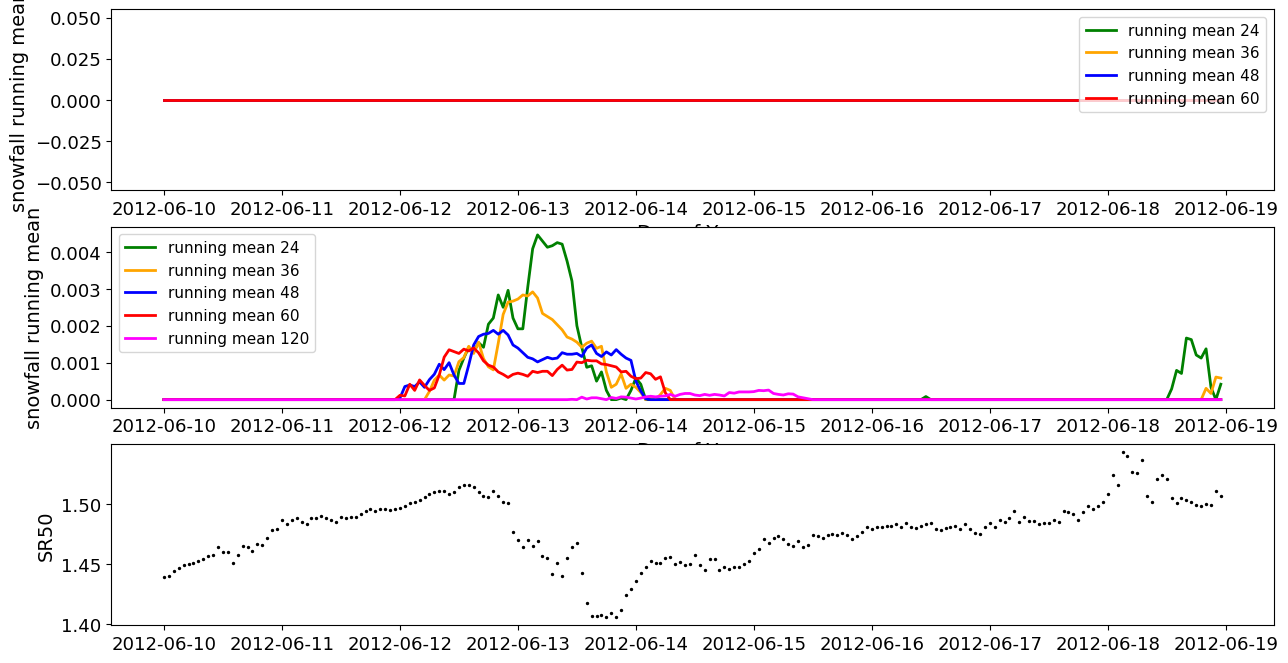

In [56]:
start = "2012-06-10"
end = "2012-06-18"

#plot GAM splines without intercept explicitly added
fig = plt.figure(figsize=(15,8))

#ax.scatter(jjmc2[start:end].index, jjmc2["SR_snowfall"][start:end], color='k', s = 8, label='SR50')
ax = fig.add_subplot(3,1,1)

ax.plot(jjmc3[start:end].index, np.where((jjmc3["24mean_snowfall"][start:end] > 0.001) & (jjmc3["daily_albedo"][start:end] > 0.8), jjmc3["24mean_snowfall"][start:end], 0), color= "green", linewidth = 2, label = "running mean 24")
ax.plot(jjmc3[start:end].index, np.where((jjmc3["36mean_snowfall"][start:end] > 0.001) & (jjmc3["daily_albedo"][start:end] > 0.8), jjmc3["36mean_snowfall"][start:end], 0), color= "orange", linewidth = 2, label = "running mean 36")
ax.plot(jjmc3[start:end].index, np.where((jjmc3["48mean_snowfall"][start:end] > 0.001) & (jjmc3["daily_albedo"][start:end] > 0.8), jjmc3["48mean_snowfall"][start:end], 0), color= "b", linewidth = 2, label = "running mean 48")
ax.plot(jjmc3[start:end].index, np.where((jjmc3["60mean_snowfall"][start:end] > 0.001) & (jjmc3["daily_albedo"][start:end] > 0.8), jjmc3["60mean_snowfall"][start:end], 0), color= "r", linewidth = 2, label = "running mean 60")
#ax.plot(jjmc2[start:end].index, jjmc2["72mean_snowfall"][start:end], color= "cyan", linewidth = 2, label = "running mean 72")
#ax.plot(jjmc2[start:end].index, jjmc2["72mean_snowfall"][start:end], color= "cyan", linewidth = 2, label = "running mean 72")
#ax.plot(x[0:364], fit_between.predict(x)[0:364], color= "g", label = "GAM with 15 splines")
ax.set_xlabel('Day of Year')
ax.set_ylabel('snowfall running mean')
ax.legend()

ax = fig.add_subplot(3,1,2)

ax.plot(jjmc3[start:end].index, np.where(jjmc3["24mean_snowfall"][start:end] > 0.00, jjmc3["24mean_snowfall"][start:end], 0), color= "green", linewidth = 2, label = "running mean 24")
ax.plot(jjmc3[start:end].index, np.where(jjmc3["36mean_snowfall"][start:end] > 0.00, jjmc3["36mean_snowfall"][start:end], 0), color= "orange", linewidth = 2, label = "running mean 36")
ax.plot(jjmc3[start:end].index, np.where(jjmc3["48mean_snowfall"][start:end] > 0.00, jjmc3["48mean_snowfall"][start:end], 0), color= "b", linewidth = 2, label = "running mean 48")
ax.plot(jjmc3[start:end].index, np.where(jjmc3["60mean_snowfall"][start:end] > 0.00, jjmc3["60mean_snowfall"][start:end], 0), color= "r", linewidth = 2, label = "running mean 60")
ax.plot(jjmc3[start:end].index, np.where(jjmc3["120mean_snowfall"][start:end] > 0.00, jjmc3["120mean_snowfall"][start:end], 0), color= "magenta", linewidth = 2, label = "running mean 120")

#ax.plot(jjmc2[start:end].index, jjmc2["72mean_snowfall"][start:end], color= "cyan", linewidth = 2, label = "running mean 72")
#ax.plot(x[0:364], fit_between.predict(x)[0:364], color= "g", label = "GAM with 15 splines")
ax.set_xlabel('Day of Year')
ax.set_ylabel('snowfall running mean')
ax.legend()

ax2 = fig.add_subplot(3,1,3)
ax2.scatter(jjmc3[start:end].index, jjmc3["SR50 cor"][start:end], color = "k", s = 2)
ax2.set_ylabel("SR50")
#

#plt.savefig(fr"C:\Users\leopo\Master\Thesis\images\jjmc_precipitation\snowfall_GAM_runmean_{start}_{end}.pdf")
plt.show()

In [57]:
#add SR50_timeseries to data
jjmc["SR50_timeseries"] = np.zeros(len(jjmc))

#indices
com_ind1 = jjmc1.index.intersection(jjmc.index)
com_ind2 = jjmc2.index.intersection(jjmc.index)
com_ind3 = jjmc3.index.intersection(jjmc.index)
com_ind4 = jjmc4.index.intersection(jjmc.index)

jjmc["SR50_timeseries"].loc[com_ind1] = jjmc1["SR50_timeseries"].loc[com_ind1].values
jjmc["SR50_timeseries"].loc[com_ind2] = jjmc2["SR50_timeseries"].loc[com_ind2].values
jjmc["SR50_timeseries"].loc[com_ind3] = jjmc3["SR50_timeseries"].loc[com_ind3].values
jjmc["SR50_timeseries"].loc[com_ind4] = jjmc4["SR50_timeseries"].loc[com_ind4].values

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\181304616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SR50_timeseries"] = np.zeros(len(jjmc))
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\181304616.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SR50_timeseries"].loc[com_ind1] = jjmc1["SR50_timeseries"].loc[com_ind1].values
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\181304616.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [58]:
#add snowfall to data
jjmc["12mean_snowfall"] = np.zeros(len(jjmc))
jjmc["24mean_snowfall"] = np.zeros(len(jjmc))
jjmc["36mean_snowfall"] = np.zeros(len(jjmc))
jjmc["48mean_snowfall"] = np.zeros(len(jjmc))
jjmc["60mean_snowfall"] = np.zeros(len(jjmc))
jjmc["72mean_snowfall"] = np.zeros(len(jjmc))
jjmc["108mean_snowfall"] = np.zeros(len(jjmc))
jjmc["120mean_snowfall"] = np.zeros(len(jjmc))
jjmc["168mean_snowfall"] = np.zeros(len(jjmc))

#add SR50_runmean to data
jjmc["SR50_runmean12"] = np.zeros(len(jjmc))
jjmc["SR50_runmean24"] = np.zeros(len(jjmc))
jjmc["SR50_runmean36"] = np.zeros(len(jjmc))
jjmc["SR50_runmean48"] = np.zeros(len(jjmc))
jjmc["SR50_runmean60"] = np.zeros(len(jjmc))
jjmc["SR50_runmean72"] = np.zeros(len(jjmc))
jjmc["SR50_runmean108"] = np.zeros(len(jjmc))
jjmc["SR50_runmean120"] = np.zeros(len(jjmc))
jjmc["SR50_runmean168"] = np.zeros(len(jjmc))

#indices
com_ind1 = jjmc1.index.intersection(jjmc.index)
com_ind2 = jjmc2.index.intersection(jjmc.index)
com_ind3 = jjmc3.index.intersection(jjmc.index)
com_ind4 = jjmc4.index.intersection(jjmc.index)

for runmean in ["12mean_snowfall", "24mean_snowfall", "36mean_snowfall", "48mean_snowfall", "60mean_snowfall", 
                "72mean_snowfall", "108mean_snowfall", "120mean_snowfall", "168mean_snowfall"]:
    
    jjmc[runmean].loc[com_ind1] = jjmc1[runmean].loc[com_ind1].values
    
    jjmc[runmean].loc[com_ind2] = jjmc2[runmean].loc[com_ind2].values

    jjmc[runmean].loc[com_ind3] = jjmc3[runmean].loc[com_ind3].values
    
    jjmc[runmean].loc[com_ind4] = jjmc4[runmean].loc[com_ind4].values
    
for runmean in ["SR50_runmean12", "SR50_runmean24", "SR50_runmean36", "SR50_runmean48", "SR50_runmean60", 
                "SR50_runmean72", "SR50_runmean108", "120mean_snowfall", "168mean_snowfall"]:
    
    jjmc[runmean].loc[com_ind1] = jjmc1[runmean].loc[com_ind1].values
    
    jjmc[runmean].loc[com_ind2] = jjmc2[runmean].loc[com_ind2].values

    jjmc[runmean].loc[com_ind3] = jjmc3[runmean].loc[com_ind3].values
    
    jjmc[runmean].loc[com_ind4] = jjmc4[runmean].loc[com_ind4].values    

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3639845652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["12mean_snowfall"] = np.zeros(len(jjmc))
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3639845652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["24mean_snowfall"] = np.zeros(len(jjmc))
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\3639845652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

## total precipitation

For cosipy I want to add snowfall (--> SWE, calculate density with formula of cosipy) and rain measurements together to one total precipitation column.
For that i take Snow if:
- T <= 0°C and Albedo > 0.7
- Snow amount larger than precipitation
and rain otherwise.

In [63]:
snow_density = np.maximum(109.0+6.0*(jjmc["AT 2m"])+26.0*np.sqrt(jjmc["3m Wind (m/s)"]), 50)

monthly_means = snow_density.groupby(snow_density.index.month).mean()

# Replace NaN values with respective monthly means
snow_density = snow_density.fillna(snow_density.index.to_series().dt.month.map(monthly_means))
jjmc["snow_density"] = snow_density

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\96612043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["snow_density"] = snow_density


0.37056250000000457

In [64]:
ice_density = 917

jjmc["12mean_SWE"] = jjmc["12mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["24mean_SWE"] = jjmc["24mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["36mean_SWE"] = jjmc["36mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["48mean_SWE"] = jjmc["48mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["72mean_SWE"] = jjmc["72mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["108mean_SWE"] = jjmc["108mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["120mean_SWE"] = jjmc["120mean_snowfall"] * (snow_density/ice_density) * 1000
jjmc["168mean_SWE"] = jjmc["168mean_snowfall"] * (snow_density/ice_density) * 1000

#improvements before 26.03
#jjmc["total_precip_24mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["24mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["24mean_SWE"], jjmc["rain (mm)"])
#jjmc["total_precip_36mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["36mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["36mean_SWE"], jjmc["rain (mm)"])
#jjmc["total_precip_12mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["12mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["12mean_SWE"], jjmc["rain (mm)"])

#jjmc["total_precip_72mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["72mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["72mean_SWE"], jjmc["rain (mm)"])

#jjmc["total_precip_108mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["108mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["12mean_SWE"], jjmc["rain (mm)"])
#jjmc["total_precip_120mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["120mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["120mean_SWE"], jjmc["rain (mm)"])
#jjmc["total_precip_168mean"] = np.where((jjmc["AT 2m"] <= 0) & (jjmc["168mean_SWE"] > jjmc["rain (mm)"]),
#                                       jjmc["168mean_SWE"], jjmc["rain (mm)"])

#improvements after 26.03
jjmc["total_precip_24mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["24mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["24mean_SWE"])
jjmc["total_precip_36mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["36mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["36mean_SWE"])
jjmc["total_precip_12mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["12mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["12mean_SWE"])
jjmc["total_precip_48mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["48mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["48mean_SWE"])
jjmc["total_precip_72mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["72mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["72mean_SWE"])
jjmc["total_precip_108mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["108mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["108mean_SWE"])
jjmc["total_precip_120mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["120mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["120mean_SWE"])
jjmc["total_precip_168mean"] = np.where((jjmc["AT 2m"] > 0) & (jjmc["rain (mm)"] > 0) & (jjmc["168mean_SWE"] <= 0) & (jjmc.index.month >= 5) & (jjmc.index.month <= 9),
                                       jjmc["rain (mm)"], jjmc["168mean_SWE"])


C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2137519492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["12mean_SWE"] = jjmc["12mean_snowfall"] * (snow_density/ice_density) * 1000
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2137519492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["24mean_SWE"] = jjmc["24mean_snowfall"] * (snow_density/ice_density) * 1000
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2137519492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

## Snowfall sums during hydrological years

In [83]:
for model in ["12mean_SWE", "24mean_SWE", "36mean_SWE", "48mean_SWE", "72mean_SWE", "108mean_SWE", "120mean_SWE"]:
    print(model)
    for year in np.arange(2008, 2015):
        print(year, " ", jjmc[model][f"{year}-09":f"{year+1}-08"].sum().round())
        

12mean_SWE
2008   448.0
2009   285.0
2010   502.0
2011   397.0
2012   395.0
2013   507.0
2014   155.0
24mean_SWE
2008   284.0
2009   146.0
2010   290.0
2011   239.0
2012   251.0
2013   344.0
2014   108.0
36mean_SWE
2008   229.0
2009   116.0
2010   221.0
2011   187.0
2012   207.0
2013   284.0
2014   88.0
48mean_SWE
2008   195.0
2009   98.0
2010   179.0
2011   157.0
2012   176.0
2013   249.0
2014   77.0
72mean_SWE
2008   150.0
2009   77.0
2010   130.0
2011   125.0
2012   142.0
2013   207.0
2014   63.0
108mean_SWE
2008   115.0
2009   61.0
2010   93.0
2011   101.0
2012   117.0
2013   167.0
2014   52.0
120mean_SWE
2008   104.0
2009   56.0
2010   86.0
2011   95.0
2012   109.0
2013   157.0
2014   49.0


In [87]:
jjmc.

Index(['Unnamed: 0', 'Year', 'Day', 'Time', 'batt volt', 'log temp', 'AT 3m',
       'RH 3m', 'AT 2m', 'RH 2m',
       ...
       'total_precip_12mean', 'total_precip_48mean', 'total_precip_72mean',
       'total_precip_108mean', 'total_precip_120mean', 'total_precip_168mean',
       'total_precip_24combinedmean', 'total_precip_36combinedmean',
       'total_precip_108_24combinedmean', 'total_precip_108_36combinedmean'],
      dtype='object', length=115)

## Data availability of Sonic Ranger

In [86]:
for year in np.arange(2008, 2015):
    N_data = jjmc[f"{year}-09":f"{year+1}-08"]["SR50 cor"].notna().sum()
    data_avail = N_data / len(jjmc[f"{year}-09":f"{year+1}-08"])
    print(year, " ", data_avail*100)

2008   92.77397260273973
2009   65.55936073059361
2010   99.90867579908675
2011   99.8747723132969
2012   78.27625570776256
2013   88.88127853881278
2014   92.45218579234972


## Data availability of Rain Gauge

In [88]:
for year in np.arange(2008, 2015):
    N_data = jjmc[f"{year}-09":f"{year+1}-08"]["rain (mm)"].notna().sum()
    data_avail = N_data / len(jjmc[f"{year}-09":f"{year+1}-08"])
    print(year, " ", data_avail*100)

2008   100.0
2009   65.59360730593608
2010   100.0
2011   100.0
2012   78.64155251141553
2013   90.47945205479452
2014   93.68169398907104


## Total precip sums during hydrological years

In [92]:
for model in ["total_precip_12mean", "total_precip_24mean", "total_precip_36mean", 
              "total_precip_48mean", "total_precip_72mean", "total_precip_108mean", "total_precip_120mean"]:
    print(model)
    for year in np.arange(2008, 2015):
        print(year, " ", jjmc[model][f"{year}-09":f"{year+1}-08"].sum())


total_precip_12mean
2008   606.0318885487249
2009   525.3628972741703
2010   612.6565818666078
2011   625.6259107696701
2012   664.8915774098839
2013   709.8655468751045
2014   161.37137668928608
total_precip_24mean
2008   444.3477748382869
2009   410.3989068733599
2010   402.29487608395203
2011   479.386369892065
2012   518.9366696724694
2013   554.5642313554367
2014   111.76085983087555
total_precip_36mean
2008   383.0437564540074
2009   381.0082016754412
2010   343.1080810811561
2011   419.9636228146449
2012   463.95242478923336
2013   496.9191390314742
2014   89.30140728348933
total_precip_48mean
2008   350.6636219912933
2009   368.4743404632196
2010   301.1199199297312
2011   386.37509064507674
2012   434.9105655927332
2013   456.3225338537453
2014   81.66845882530151
total_precip_72mean
2008   317.76007174980776
2009   345.83183499972574
2010   264.15451695513093
2011   362.025647807116
2012   409.16825106797637
2013   411.43957191438915
2014   65.38248983649446
total_precip_108m

In [67]:
for d, mean in zip([12,24,36,108,120, 168, 24, 36],["total_precip_12mean", "total_precip_24mean", "total_precip_36mean", "total_precip_108mean", "total_precip_120mean", "total_precip_168mean", "total_precip_24combinedmean", "total_precip_36combinedmean"]):
    print(d, jjmc["2010"][mean].loc[(jjmc["2010"].index.month >= 6) & (jjmc["2010"].index.month <= 8)].sum())
    print(d, jjmc["2010"]["rain (mm)"].loc[(jjmc["2010"].index.month >= 6) & (jjmc["2010"].index.month <= 8)].sum())

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2212457246.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(d, jjmc["2010"][mean].loc[(jjmc["2010"].index.month >= 6) & (jjmc["2010"].index.month <= 8)].sum())
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2212457246.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(d, jjmc["2010"]["rain (mm)"].loc[(jjmc["2010"].index.month >= 6) & (jjmc["2010"].index.month <= 8)].sum())


12 352.4396113849564
12 292.856
24 299.4474654231442
24 292.856
36 287.3752898797775
36 292.856
108 275.03707480436367
108 292.856
120 272.7232042476842
120 292.856
168 271.84506975751395
168 292.856
24 316.4932252125725
24 292.856
36 304.86060598498915
36 292.856


122.49025727985337

### ERA5 data
for comparison with the calculated/estimated snowfall and precipitation amounts from the Sonic ranger data and the rain gauge, I also use ERA5 data for the grid point closest to McCall, which is at 96.25°N and -143.75°W. I use snowfall, total precipitation and snow depth. Snow depth and Snowfall are in m SWE, total precipitation is in m

In [79]:
#load ERA5 precip data
folder = r"C:\Users\leopo\Master\Thesis\data\era5\precipitation"
era5_precip = []
for year in np.arange(2008, 2015):
    file = fr"\precip_{year}.nc"
    data = xr.open_dataset(folder+file)
    era5_precip.append(data)
    
#in pandas dataframe
dfs = []
for dataset in era5_precip:
    df = dataset.sel(longitude = -143.75, latitude = 69.25).to_dataframe().reset_index()
    dfs.append(df)

# Schritt 2: Füge die Variable "time" als Index hinzu
for i, df in enumerate(dfs):
    dfs[i] = df.set_index('time')

# Schritt 3: Führe alle DataFrames in einem einzelnen DataFrame zusammen
era5_precip = pd.concat(dfs)
    

## Total precipitation or snowfall from ERA5

In [90]:
era5_precip["sf_narm"] = np.nan
era5_precip["tp_narm"] = np.nan

era5_precip["sf_narm"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["sf"]["2008-08-17 01:00":])
era5_precip["tp_narm"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["tp"]["2008-08-17 01:00":])

for year in np.arange(2008, 2015):
    #year = str(year)
    print(year, ":")
    print("era5 :", np.round(era5_precip["tp"][f"{year}-09":f"{year+1}-08"].sum() * 1000))
    print("era5 sf no nan :", era5_precip["sf_narm"][f"{year}-09":f"{year+1}-08"].sum() * 1000)
    print("era5 tp no nan :", era5_precip["tp_narm"][f"{year}-09":f"{year+1}-08"].sum() * 1000)
    
    #print("12h :", jjmc["total_precip_12mean"][year].sum())
    #print("24h :", jjmc["total_precip_24mean"][year].sum())
    #print("36h :", jjmc["total_precip_36mean"][year].sum())
    #print("48h :", jjmc["total_precip_48mean"][year].sum())
    #print("72h :", jjmc["total_precip_72mean"][year].sum())
    #print("108h :", jjmc["total_precip_108mean"][year].sum())
    #print("120h :", jjmc["total_precip_120mean"][year].sum())
    

2008 :
era5 : 517.0
era5 sf no nan : 264.27111285738647
era5 tp no nan : 399.87214806023985
2009 :
era5 : 552.0
era5 sf no nan : 106.80038039572537
era5 tp no nan : 507.0951316738501
2010 :
era5 : 414.0
era5 sf no nan : 186.58565916121006
era5 tp no nan : 413.40941516682506
2011 :
era5 : 568.0
era5 sf no nan : 204.97126135160215
era5 tp no nan : 565.0751665234566
2012 :
era5 : 573.0
era5 sf no nan : 225.177390180761
era5 tp no nan : 527.8245114022866
2013 :
era5 : 516.0
era5 sf no nan : 268.41082610189915
era5 tp no nan : 477.86764171905816
2014 :
era5 : 118.0
era5 sf no nan : 92.28933390113525
era5 tp no nan : 100.36171937827021


C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\914287803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5_precip["sf_narm"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["sf"]["2008-08-17 01:00":])
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\914287803.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5_precip["tp_narm"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["tp"]["2008-08-17 01:00":])


In [182]:
for year in np.arange(2008, 2015):
    year = str(year)
    print(year, ":")
    print((len(jjmc[year]) - len(jjmc[year].loc[jjmc[year]["rain (mm)"].isnull()])) / len(jjmc[year]))

2008 :
1.0
2009 :
0.9014840182648401
2010 :
0.7544520547945206
2011 :


C:\Users\leopo\AppData\Local\Temp\ipykernel_32284\1637779710.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print((len(jjmc[year]) - len(jjmc[year].loc[jjmc[year]["rain (mm)"].isnull()])) / len(jjmc[year]))


1.0
2012 :
0.9938524590163934
2013 :
0.7437214611872146
2014 :
0.9325342465753425


In [177]:
len(jjmc["2010"].loc[jjmc["2010"]["SR50 cor"].isnull()])

C:\Users\leopo\AppData\Local\Temp\ipykernel_32284\3421129266.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  len(jjmc["2010"].loc[jjmc["2010"]["SR50 cor"].isnull()])


2156

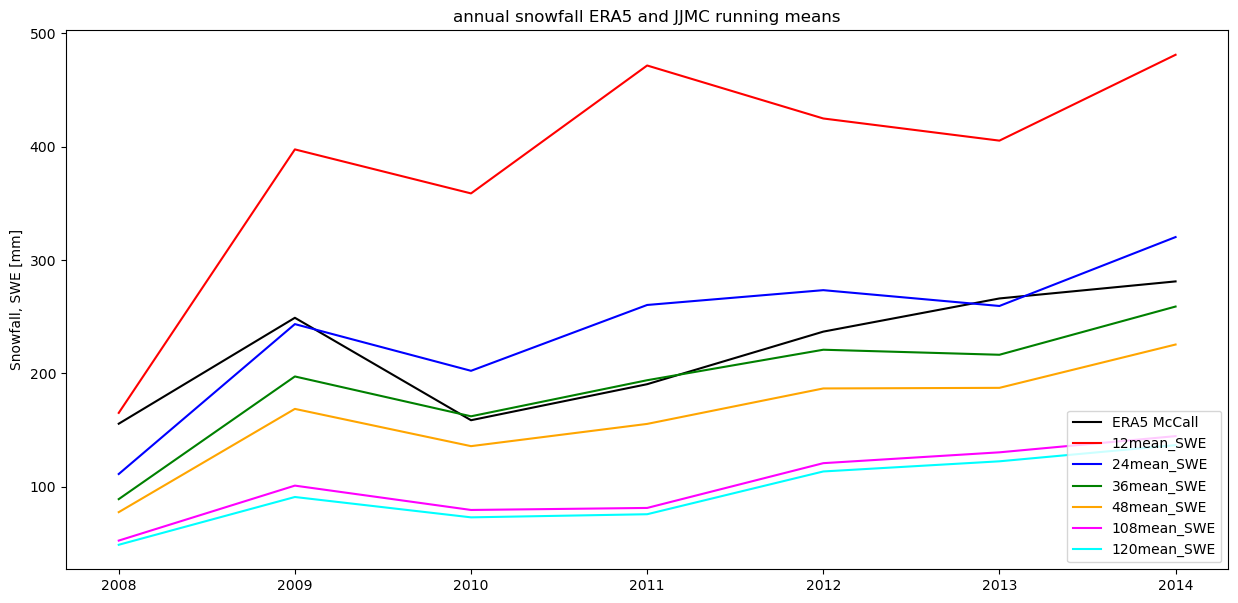

In [96]:
#annual sums
jjmc_annual_sum = jjmc[["12mean_SWE", "24mean_SWE", "36mean_SWE", "48mean_SWE", "108mean_SWE", "120mean_SWE"]].groupby(jjmc.index.year).sum()
era5_annual_sum = era5_precip["sf"].groupby(era5_precip.index.year).sum() * 1000

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(era5_annual_sum, color = "k", label="ERA5 McCall")
for mean, c in zip(["12mean_SWE", "24mean_SWE", "36mean_SWE", "48mean_SWE", "108mean_SWE", "120mean_SWE"], ["r", "b", "green", "orange", "magenta", "cyan"]):
    ax.plot(jjmc_annual_sum[mean], color = c, label = mean)
    
ax.set_ylabel("Snowfall, SWE [mm]"); ax.set_title("annual snowfall ERA5 and JJMC running means")
ax.legend(loc = "lower right")

### annual sums precipitation

plot the annual sums of snowfall and total precipitation of era5 and JJMC to compare, which running means align best with the data.
- annual snowfall
- annual total precipitation running means and also combined running means

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\606549516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5_precip["sf_nanex"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["sf"]["2008-08-17 01:00":])


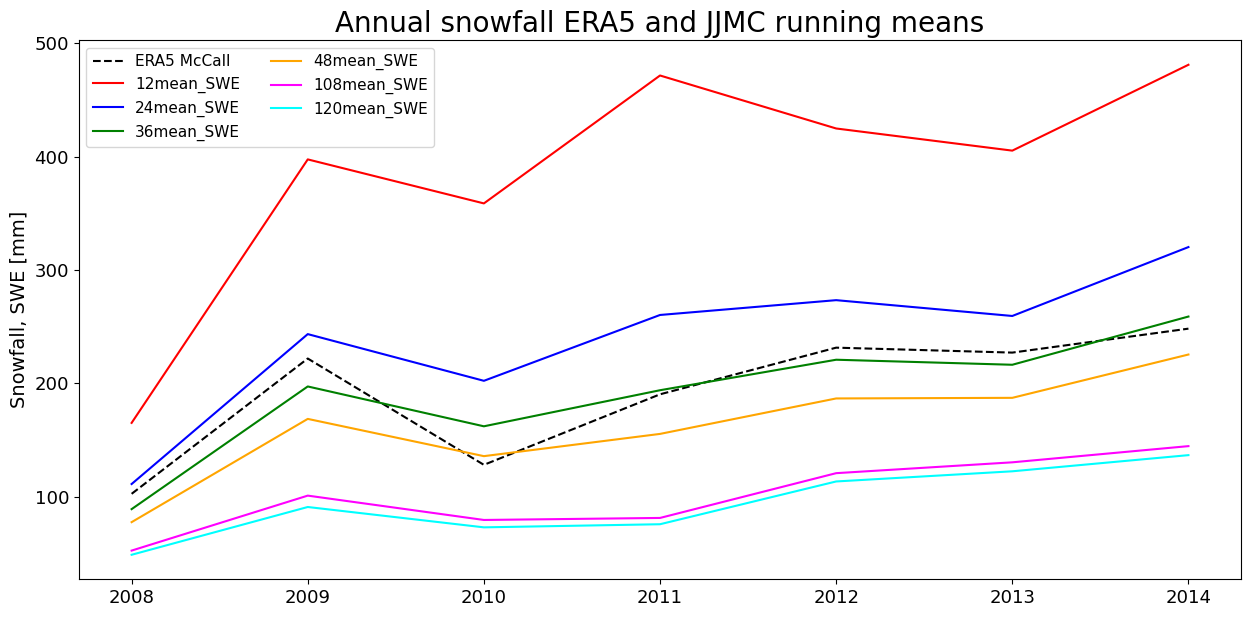

In [94]:
#annual sums if data gaps of JJMC are also included in ERA5
jjmc_annual_sum = jjmc[["12mean_SWE", "24mean_SWE", "36mean_SWE", "48mean_SWE", "108mean_SWE", "120mean_SWE"]].groupby(jjmc.index.year).sum()
#exclude nans from JJMC
era5_precip["sf_nanex"] = np.nan
era5_precip["sf_nanex"]["2008-08-17 01:00":] = np.where(jjmc["SR50 cor"].isnull(), np.nan, era5_precip["sf"]["2008-08-17 01:00":])
era5_annual_sum = era5_precip["sf_nanex"].groupby(era5_precip.index.year).sum() * 1000


fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(era5_annual_sum, color = "k", linestyle = "dashed", label="ERA5 McCall")
for mean, c in zip(["12mean_SWE", "24mean_SWE", "36mean_SWE", "48mean_SWE", "108mean_SWE", "120mean_SWE"], ["r", "b", "green", "orange", "magenta", "cyan"]):
    ax.plot(jjmc_annual_sum[mean], color = c, label = mean)
    
ax.set_ylabel("Snowfall, SWE [mm]"); ax.set_title("Annual snowfall ERA5 and JJMC running means", fontsize = 20)
ax.legend(loc = "upper left", ncol = 2)

#plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_precipitation\era5_runmean_comparison\sf_annual.png")
#plt.close()
plt.show()

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\4162006775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5_precip["tp_nanex"]["2008-08-17 01:00":] = np.where(jjmc["total_precip_12mean"].isnull(), np.nan, era5_precip["tp"]["2008-08-17 01:00":])


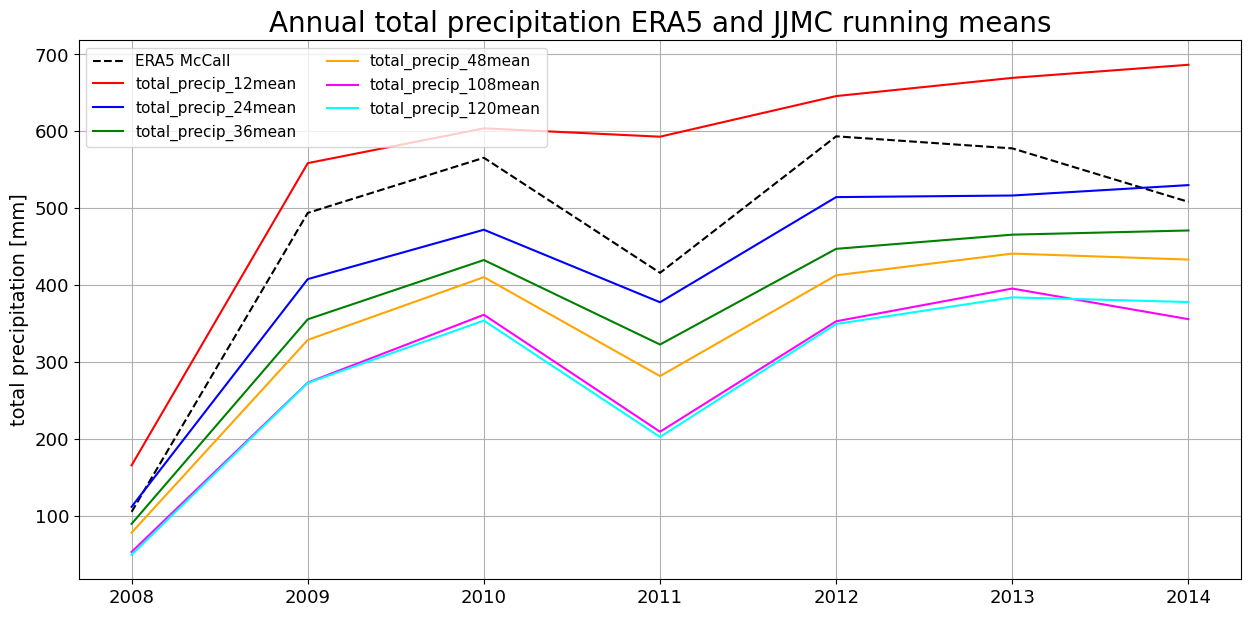

In [95]:
#annual sums if data gaps of JJMC are also included in ERA5
jjmc_annual_sum = jjmc[["total_precip_12mean", "total_precip_24mean", "total_precip_36mean", "total_precip_48mean", "total_precip_108mean", "total_precip_120mean"]].groupby(jjmc.index.year).sum()
#exclude nans from JJMC
era5_precip["tp_nanex"] = np.nan
era5_precip["tp_nanex"]["2008-08-17 01:00":] = np.where(jjmc["total_precip_12mean"].isnull(), np.nan, era5_precip["tp"]["2008-08-17 01:00":])
era5_annual_sum = era5_precip["tp_nanex"].groupby(era5_precip.index.year).sum() * 1000


fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(era5_annual_sum, color = "k", label="ERA5 McCall", linestyle = "dashed")
for mean, c in zip(["total_precip_12mean", "total_precip_24mean", "total_precip_36mean", "total_precip_48mean","total_precip_108mean", "total_precip_120mean"], ["r", "b", "green", "orange", "magenta", "cyan"]):
    ax.plot(jjmc_annual_sum[mean], color = c, label = mean)
    
ax.set_ylabel("total precipitation [mm]"); ax.set_title("Annual total precipitation ERA5 and JJMC running means", fontsize = 20)
ax.legend(loc = "upper left", ncol = 2)
ax.grid()

#plt.savefig(r"C:\Users\leopo\Master\Thesis\images\jjmc_precipitation\era5_runmean_comparison\tp_annual1.png")
#plt.close()
plt.show()

### era5 to JJMC data
add era5 variables sf, sd and tp to JJMC dataset. They are in m SWE -->
- snowfall: jjmc["12mean_SWE"] = jjmc["12mean_snowfall"] * (snow_density/ice_density) * 1000
            in [m]: era5_snowfall = era5_SWE * ice_density/snow_density

- total precipiation: [m] --> only have to multiply by 1000



In [96]:
com_ind4 = jjmc4.index.intersection(jjmc.index)

jjmc["SR50_timeseries"].loc[com_ind1] = jjmc1["SR50_timeseries"].loc[com_ind1].values

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2954970362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SR50_timeseries"].loc[com_ind1] = jjmc1["SR50_timeseries"].loc[com_ind1].values


In [97]:
jjmc["era5_total_precip"] = np.nan
jjmc["era5_snowfall"] = np.nan
jjmc["era5_sf_mSWE"] = np.nan

#common indices
era5_comind = era5_precip.index.intersection(jjmc.index)

#add era5 to jjmc
jjmc["era5_total_precip"].loc[era5_comind] = era5_precip["tp"].loc[era5_comind].values * 1000
jjmc["era5_snowfall"].loc[era5_comind] = era5_precip["sf"].loc[era5_comind].values * (ice_density / jjmc["snow_density"])
jjmc["era5_sf_mSWE"].loc[era5_comind] = era5_precip["sf"].loc[era5_comind].values
jjmc["era5_rain"] = jjmc["era5_total_precip"] - jjmc["era5_sf_mSWE"] * 1000

C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2042536741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["era5_total_precip"] = np.nan
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2042536741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["era5_snowfall"] = np.nan
C:\Users\leopo\AppData\Local\Temp\ipykernel_14088\2042536741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<Axes: xlabel='utc_time'>

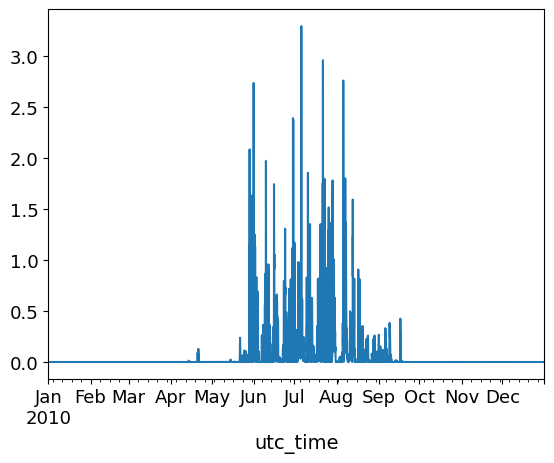

In [98]:
era5_rain = era5_precip["tp"] - era5_precip["sf"]
jjmc["era5_rain"]["2010"].plot()

## save data

In [99]:
jjmc["total_precip_12mean"]["09-2010":"08-2011"].sum()

612.6565818666078

In [100]:
#only important columns
columns = ["Datetime", "AT 2m", "RH 2m", "pressure (mb)", "pressure cos", "3m Wind (m/s)", "3m Wind dir", "3m Wind Max (m/s)", "rain (mm)", "total_precip_12mean",
           "total_precip_24mean", "total_precip_36mean", "total_precip_72mean",  "total_precip_108mean",  "total_precip_120mean",  "total_precip_168mean",
           "total_precip_24combinedmean", "total_precip_36combinedmean", "total_precip_108_24combinedmean", "total_precip_108_36combinedmean",
           "era5_total_precip", "era5_snowfall", "era5_sf_mSWE", "era5_rain",
           "12mean_snowfall", "24mean_snowfall", "36mean_snowfall", "72mean_snowfall", "108mean_snowfall", "120mean_snowfall", "168mean_snowfall",
           "SR50_runmean12", "SR50_runmean24", "SR50_runmean36", "SR50_runmean72", "SR50_runmean108", "SR50_runmean120", "SR50_runmean168","SR50 cor","SR50_timeseries",
           "CM3 up Cal", 'CM3 Down Cal', "CG3 up cal", "CG3 down cal", "SW_net", "daily_albedo", "snow_density"]
jjmc_save = jjmc[columns].copy()

#corrections for making the dataset work with cosipy
jjmc_save = jjmc_save.rename_axis("TIMESTAMP")


In [101]:
target_directory = r'C:\Users\leopo\Master\Thesis\data\data_shaped'
filename_jjmc = r'\jjmc_cosipy_cleaned29102024.csv'
#filename_jjmcfoehn = r'\jjmc_foehn_cosipy.csv'
#filename_jjmcnofoehn = r'\jjmc_nofoehn_cosipy.csv'

jjmc_save.to_csv(target_directory+filename_jjmc, na_rep = 'NAN')

In [466]:
#snowfall = inverse of distance change
jjmc["snowfall"] = jjmc["dist_to_snow_change"].values * (-1)
#no negative snowfall
jjmc.loc[jjmc["snowfall"] < 0, "snowfall"] = 0
#no snowfall if below the accuracy of SR50 which is either 0.01 m or 0.004 * distance to surface  if that is larger than 0.01m
jjmc.loc[jjmc["snowfall"] <= jjmc["sr50_accuracy"], "snowfall"] = 0

#snowfall only if daily sum is larger 0
jjmc.loc[jjmc["daily_acc_snow"] <= 0, "snowfall"] = 0

#jjmc["snowfall"].loc[jjmc["snowfall"] > 0.2] = 0
#jjmc["snowfall"].loc[jjmc["AT 2m"] > 2] = 0

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2295517531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["snowfall"] = jjmc["dist_to_snow_change"].values * (-1)


C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\810473920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["daily_acc_snow"] = daily_sums * (-1)


In [444]:
print("hours in data: ", len(jjmc["snowfall"]), ", hours with snowfall: ", len(jjmc["snowfall"]) - len(jjmc["snowfall"].loc[jjmc["snowfall"] == 0]))

hours in data:  55871 , hours with snowfall:  2612


In [427]:
365* 24 * 0.0015 * 300

3942.0

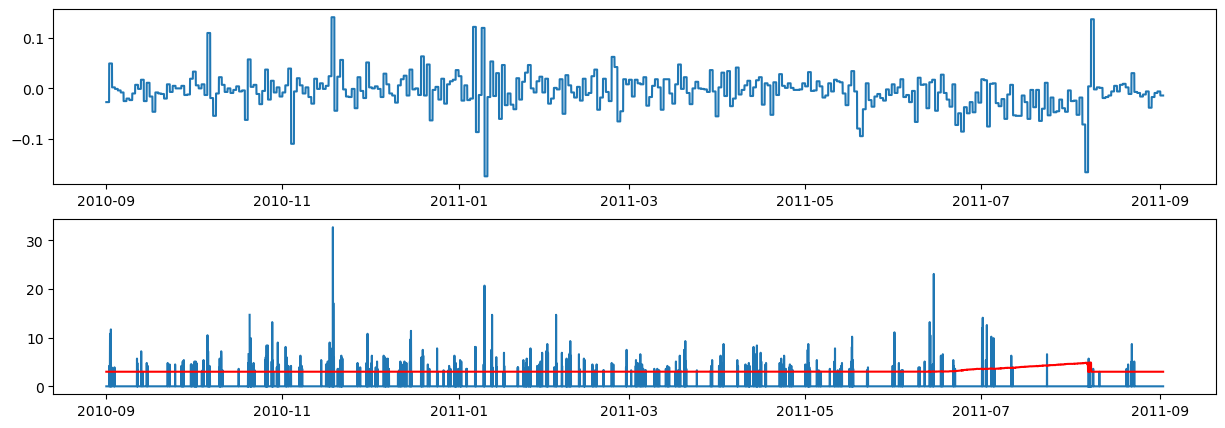

In [467]:
fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(2,1,1)
ax.plot(jjmc["2010-09-01":"2011-09-01"].index, jjmc["daily_acc_snow"]["2010-09-01":"2011-09-01"])

ax = fig.add_subplot(2,1,2)
ax.plot(jjmc["2010-09-01":"2011-09-01"].index, jjmc["snowfall"]["2010-09-01":"2011-09-01"]*300)
ax.plot(jjmc["2010-09-01":"2011-09-01"].index, jjmc["sr50_accuracy"]["2010-09-01":"2011-09-01"]*300, color = "r")

In [470]:
#annual sum of daily snow accumulation at jjmc
for year in np.arange(2008, 2015):
    data = jjmc[f"{year}"]
    snowfall = data["daily_acc_snow"][data["daily_acc_snow"] > 0].sum() * 300 * (1/24)
    rain = data["rain (mm)"].sum()
    print(f"{year}: snowfall: ", round(snowfall), ", rain (mm): ", round(rain), "total: ", round(snowfall + rain))
    

2008: snowfall:  381 , rain (mm):  8 total:  389
2009: snowfall:  1114 , rain (mm):  243 total:  1357
2010: snowfall:  567 , rain (mm):  315 total:  882
2011: snowfall:  857 , rain (mm):  177 total:  1035
2012: snowfall:  935 , rain (mm):  294 total:  1229
2013: snowfall:  669 , rain (mm):  337 total:  1007
2014: snowfall:  857 , rain (mm):  323 total:  1180


C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\3537928323.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data = jjmc[f"{year}"]


In [468]:
(1/24)*5+(1/24)*3+(1/24)*10

0.75

In [469]:
(1/24)*(5+3+10)

0.75

In [449]:
snow_density = 300 #km/m^3
jjmc["SWE"] = snow_density * jjmc["snowfall"]

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\3721677538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SWE"] = snow_density * jjmc["snowfall"]


<Axes: xlabel='utc_time'>

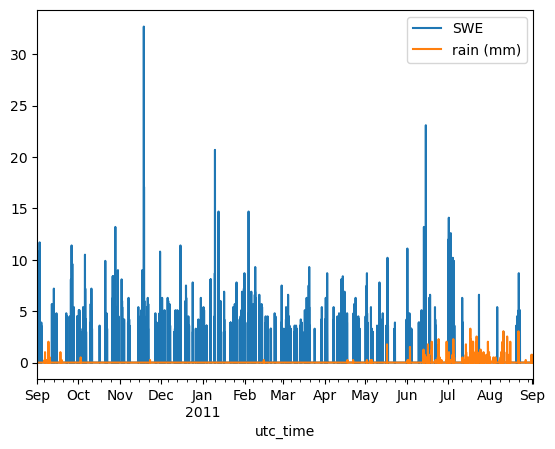

In [450]:
jjmc[["SWE", "rain (mm)"]]["2010-09-01":"2011-09-01"].plot()

In [451]:
len(jjmc["snowfall"][jjmc["snowfall"] > 0.05])

20

### snowfall corrections 
- way too much snowfall if sonic ranger data is used uncleaned
- first correction: snowfall only if albedo > 0.85

In [258]:
jjmc.columns

Index(['Unnamed: 0', 'Year', 'Day', 'Time', 'batt volt', 'log temp', 'AT 3m',
       'RH 3m', 'AT 2m', 'RH 2m', 'AT 1m', 'RH 1m', 'FWT', 'FWT Ref',
       '3m Wind (m/s)', '3m Wind dir', '3m Wind dir.1', '3m Wind Max (m/s)',
       '1m Wind (m/s)', '1m Wind Dir', '1 m Wind std', '1m Wind max(m/s)',
       'SR50 raw', 'SR50 cor', 'rain (mm)', 'rain int (mm)', 'rain time',
       'CM3 UP', 'CM3 Down', 'CG3 UP', 'CG3 Down', 'CNR_T_C', 'CNR_T_K',
       'Net Solar', 'Net Long', 'Albedo', 'Up Total', 'Down Total',
       'Net Total', 'CG3 UP Cor', 'CG3 Down Cor', 'FWT 1m', 'FWT 3m',
       'FWT 4.5m', 'FWT 6m', 'CNR1 tilt', 'CNR1 tilt.1', 'CM3 up Cal',
       'CM3 Down Cal', 'CG3 up cal', 'CG3 down cal', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Datetime', '2m AT (K)',
       'T_diff', 'pressure (mb)', 'pressure cos', 'SW_net',
       'dist_to_snow_change', 'snowfall', 'SWE', 'total precip'],
      dtype='object')

In [347]:
#define albedo
jjmc["albedo"] = jjmc["CM3 Down Cal"].values / jjmc["CM3 up Cal"].values
#fixed albedo values for hanuary, february, october, november, december because of too less solar radiation
jjmc.loc[(jjmc.index.month < 3) | (jjmc.index.month >= 10), "albedo"] = 0.85
#in other months daily average
#albedo only between 0 and 1
jjmc.loc[(jjmc["albedo"] <= 0) | (jjmc["albedo"] > 1), "albedo"] = np.nan

#only snowfall if fresh snow = albedo > 0.85
jjmc.loc[jjmc["albedo"] < 0.8, "snowfall"] = 0

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2877371828.py:2: RuntimeWarning: divide by zero encountered in divide
  jjmc["albedo"] = jjmc["CM3 Down Cal"].values / jjmc["CM3 up Cal"].values
C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2877371828.py:2: RuntimeWarning: invalid value encountered in divide
  jjmc["albedo"] = jjmc["CM3 Down Cal"].values / jjmc["CM3 up Cal"].values
C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2877371828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["albedo"] = jjmc["CM3 Down Cal"].values / jjmc["CM3 up Cal"].values


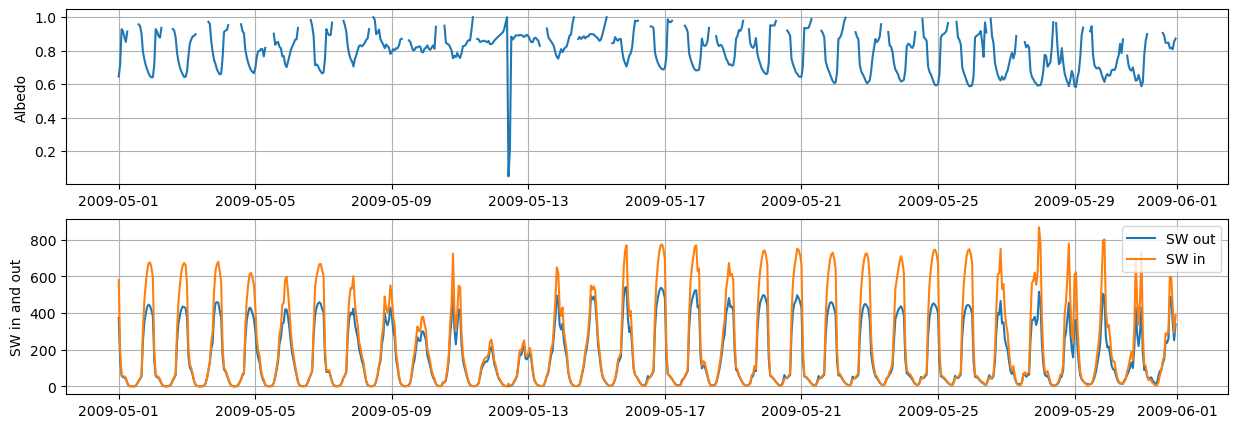

In [350]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(jjmc["albedo"]["2009-05"])
ax1.set_ylabel("Albedo")
ax1.grid()

ax2 = fig.add_subplot(2,1,2)
ax2.plot(jjmc["CM3 Down Cal"]["2009-05"], label = "SW out")
ax2.plot(jjmc["CM3 up Cal"]["2009-05"], label = "SW in")
ax2.set_ylabel("SW in and out")
ax2.legend()
ax2.grid()

In [321]:
#compute daily sum of change of distance to snow

daily_sums = jjmc.groupby(pd.Grouper(freq='D'))['dist_to_snow_change'].transform('sum')
jjmc["daily_acc_snow"] = daily_sums * (-1)

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\723736211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["daily_acc_snow"] = daily_sums * (-1)


In [472]:
6/9.2

0.6521739130434783

In [311]:
jjmc["sig_snowfall"] = jjmc["dist_to_snow_change"].loc[jjmc["dist_to_snow_change"] >= 0.1]

Int64Index([17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
            ...
            31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
           dtype='int64', name='utc_time', length=55871)

In [319]:
jjmc["daily_acc_snow"]["2009-01-03":"2009-01-07"]

utc_time
2009-01-03 00:00:00   -0.009
2009-01-03 01:00:00   -0.009
2009-01-03 02:00:00   -0.009
2009-01-03 03:00:00   -0.009
2009-01-03 04:00:00   -0.009
                       ...  
2009-01-07 19:00:00    0.004
2009-01-07 20:00:00    0.004
2009-01-07 21:00:00    0.004
2009-01-07 22:00:00    0.004
2009-01-07 23:00:00    0.004
Name: daily_acc_snow, Length: 120, dtype: float64

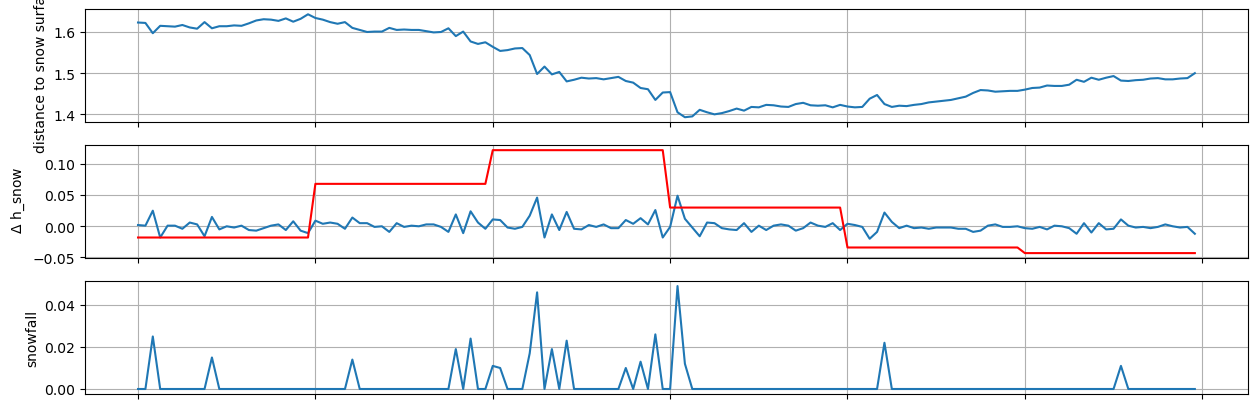

In [442]:
from matplotlib.dates import HourLocator, DayLocator, DateFormatter

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(jjmc["SR50 cor"]["2012-10-29":"2012-11-03"])
ax1.xaxis.set_major_locator(DayLocator())

# Format the date on the x-axis
date_formatter = DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_formatter)
ax1.set_xticklabels([])
ax1.set_ylabel("distance to snow surface")
ax1.grid()
#ax1.axhline(0)

ax2 = fig.add_subplot(3,1,2)
ax2.plot((-1) * jjmc["dist_to_snow_change"]["2012-10-29":"2012-11-03"])
ax2.plot(jjmc["daily_acc_snow"]["2012-10-29":"2012-11-03"], color = "r")

ax2.xaxis.set_major_locator(DayLocator())

# Format the date on the x-axis
date_formatter = DateFormatter('%Y-%m-%d')
ax2.xaxis.set_major_formatter(date_formatter)
ax2.set_xticklabels([])
ax2.set_ylabel(r" $\Delta$ h_snow")
ax2.grid()


ax3 = fig.add_subplot(3,1,3)
#ax3.plot(jjmc["daily_acc_snow"]["2009-01-03":"2009-01-31"])
ax3.plot(jjmc["snowfall"]["2012-10-29":"2012-11-03"])
ax3.xaxis.set_major_locator(DayLocator())

# Format the date on the x-axis
date_formatter = DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(date_formatter)
ax3.set_xticklabels([])
ax3.set_ylabel("snowfall")
#ax3.set_ylabel("daily $\Delta$ h_snow")
ax3.grid()



In [363]:
#annual sum of daily snow accumulation at jjmc
for year in np.arange(2008, 2015):
    data = jjmc[f"{year}"]
    snowfall = data["daily_acc_snow"][data["daily_acc_snow"] > 0]
    rain = data["rain (mm)"].sum()
    print(f"{year}: snowfall: ", round(3 * snowfall.sum()), ", rain (mm): ", round(rain), "total: ", round(3 * snowfall.sum() + rain))
    

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2412174497.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data = jjmc[f"{year}"]


2008: snowfall:  84 , rain (mm):  8 total:  92
2009: snowfall:  211 , rain (mm):  243 total:  454
2010: snowfall:  129 , rain (mm):  315 total:  444
2011: snowfall:  195 , rain (mm):  177 total:  372
2012: snowfall:  206 , rain (mm):  294 total:  499
2013: snowfall:  148 , rain (mm):  337 total:  486
2014: snowfall:  199 , rain (mm):  323 total:  522


<Axes: xlabel='utc_time'>

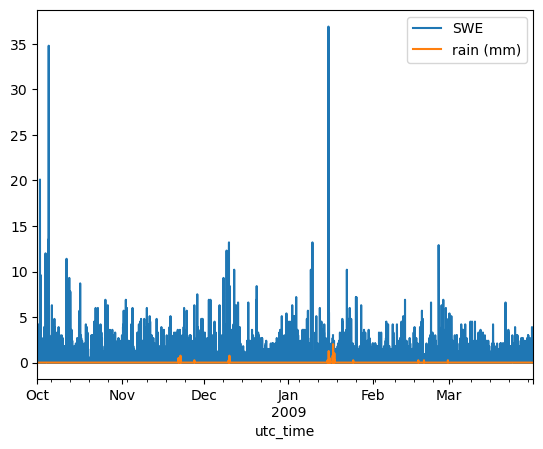

In [295]:
jjmc[["SWE", "rain (mm)"]]["2008-10-01":"2009-03-31"].plot()

In [365]:
0.004 * 1.6

0.0064

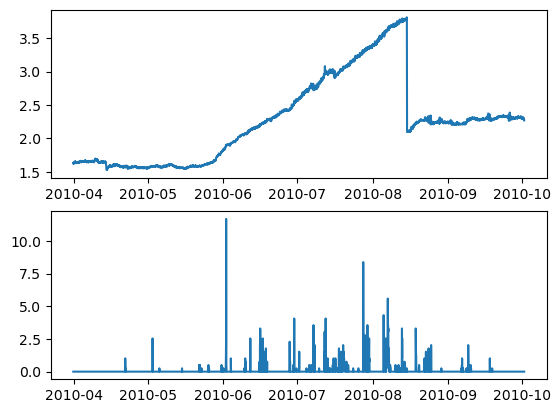

In [364]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(jjmc["SR50 cor"]["2010-03-31":"2010-10-01"])

ax2 = fig.add_subplot(2,1,2)
ax2.plot(jjmc["rain (mm)"]["2010-03-31":"2010-10-01"])

In [291]:
jjmc[["albedo", "SR50 cor", "dist_to_snow_change", "snowfall", "rain (mm)", "CM3 up Cal", "CM3 Down Cal"]]["2008-10-01 00:00:00":"2008-10-02 23:00:00"]

,albedo,SR50 cor,dist_to_snow_change,snowfall,rain (mm),CM3 up Cal,CM3 Down Cal
utc_time,,,,,,,
2008-10-01 00:00:00,0.85,1.722,0.009,0.000,0.0,62.480696,58.335415
2008-10-01 01:00:00,0.85,1.719,-0.003,0.003,0.0,51.898923,47.497388
2008-10-01 02:00:00,0.85,1.719,0.000,-0.000,0.0,24.622972,23.507514
2008-10-01 03:00:00,0.85,1.719,0.000,-0.000,0.0,4.635178,5.675267
2008-10-01 04:00:00,0.85,1.717,-0.002,0.002,0.0,0.000000,0.514769
2008-10-01 05:00:00,0.85,1.729,0.012,0.000,0.0,0.000000,1.037074
2008-10-01 06:00:00,0.85,1.731,0.002,0.000,0.0,1.685245,2.935613
2008-10-01 07:00:00,0.85,1.725,-0.006,0.006,0.0,0.000000,0.079891
2008-10-01 08:00:00,0.85,1.731,0.006,0.000,0.0,0.393425,0.650432


### total precipitation
Have (bad) measurements of Rain and snow height changes/snowfalls. Compute snow water equivalent of snowfalls and than take the larger value of Rain and snowfall per hour. Klok (2005) used a snow density of 300 $\frac{kg}{m^3}$

In [235]:
snow_density = 300 #kg/m^3
jjmc["SWE"] = snow_density * jjmc["snowfall"]

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\1004521578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["SWE"] = snow_density * jjmc["snowfall"]


In [236]:
#total precipitation
jjmc["total precip"] = jjmc[["rain (mm)", "SWE"]].max(axis=1)

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\2723928505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jjmc["total precip"] = jjmc[["rain (mm)", "SWE"]].max(axis=1)


In [237]:
jjmc["total precip"].nlargest(30)

utc_time
2013-11-14 15:00:00    45.0
2011-12-28 03:00:00    38.1
2009-01-15 18:00:00    36.9
2013-12-02 18:00:00    35.7
2008-10-05 03:00:00    34.8
2010-11-18 11:00:00    32.7
2011-06-14 13:00:00    23.1
2013-09-15 14:00:00    22.2
2011-01-10 06:00:00    21.9
2013-12-08 12:00:00    21.0
2011-01-09 23:00:00    20.7
2008-10-01 22:00:00    20.1
2014-11-21 04:00:00    19.5
2012-10-28 11:00:00    19.2
2014-11-02 06:00:00    18.9
2012-10-28 13:00:00    17.4
2010-11-18 15:00:00    17.1
2013-11-14 14:00:00    16.8
2014-09-05 03:00:00    16.2
2013-09-15 16:00:00    15.6
2014-11-21 14:00:00    15.3
2011-01-10 22:00:00    15.0
2014-08-24 07:00:00    15.0
2013-08-07 15:00:00    14.7
2009-07-15 06:00:00    14.7
2010-07-07 22:00:00    14.7
2010-10-20 15:00:00    14.7
2011-01-12 14:00:00    14.7
2011-02-03 18:00:00    14.7
2012-01-22 04:00:00    14.7
Name: total precip, dtype: float64

### lapse rates of RH and T
really bad approximations for lapse rates...dont know if I really need them in cosipy

0.0

### foehn and no foehn data
additionally to one dataset of the whole period, I want to save two smaller datasets, which contain only foehn or no foehn timesteps and furthermore are without the major data gaps so that i can use them in cosipy.

In [85]:
jjmc.columns

Index(['Unnamed: 0', 'Year', 'Day', 'Time', 'batt volt', 'log temp', 'AT 3m',
       'RH 3m', 'AT 2m', 'RH 2m', 'AT 1m', 'RH 1m', 'FWT', 'FWT Ref',
       '3m Wind (m/s)', '3m Wind dir', '3m Wind dir.1', '3m Wind Max (m/s)',
       '1m Wind (m/s)', '1m Wind Dir', '1 m Wind std', '1m Wind max(m/s)',
       'SR50 raw', 'SR50 cor', 'rain (mm)', 'rain int (mm)', 'rain time',
       'CM3 UP', 'CM3 Down', 'CG3 UP', 'CG3 Down', 'CNR_T_C', 'CNR_T_K',
       'Net Solar', 'Net Long', 'Albedo', 'Up Total', 'Down Total',
       'Net Total', 'CG3 UP Cor', 'CG3 Down Cor', 'FWT 1m', 'FWT 3m',
       'FWT 4.5m', 'FWT 6m', 'CNR1 tilt', 'CNR1 tilt.1', 'CM3 up Cal',
       'CM3 Down Cal', 'CG3 up cal', 'CG3 down cal', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Datetime',
       'pressure (mb)', '2m AT (K)', 'T_diff', 'SW_net', 'dist_to_snow_change',
       'snowfall', 'SWE', 'total precip'],
      dtype='object')

In [253]:
#jjmc_foehn = jjmc.loc[foehn["prob_jjmc_filter1"] >= 0.5]
#jjmc_nofoehn = jjmc.loc[foehn["prob_jjmc_filter1"] < 0.5]

#only important columns
columns = ["AT 2m", "RH 2m", "pressure (mb)", "pressure cos", "3m Wind (m/s)", "3m Wind dir", "3m Wind Max (m/s)",
           "total precip", "snowfall", "SR50 cor", "dist_to_snow_change",
           "CM3 up Cal", 'CM3 Down Cal', "CG3 up cal", "CG3 down cal", "SW_net"]
jjmc_save = jjmc[columns].copy()

#corrections for making the dataset work with cosipy
jjmc_save["snowfall"][0] = 0
jjmc_save = jjmc_save.rename_axis("TIMESTAMP")
#new datasets
#jjmc_foehn = jjmc_foehn[columns]
#jjmc_nofoehn = jjmc_nofoehn[columns]

C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\3919859246.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax1.plot(jjmc_save["2009"][["CM3 up Cal", "CM3 Down Cal"]])
C:\Users\leopo\AppData\Local\Temp\ipykernel_20536\3919859246.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax2.plot(jjmc_save["2009"]["CM3 Down Cal"] / jjmc_save["2009"]["CM3 up Cal"])


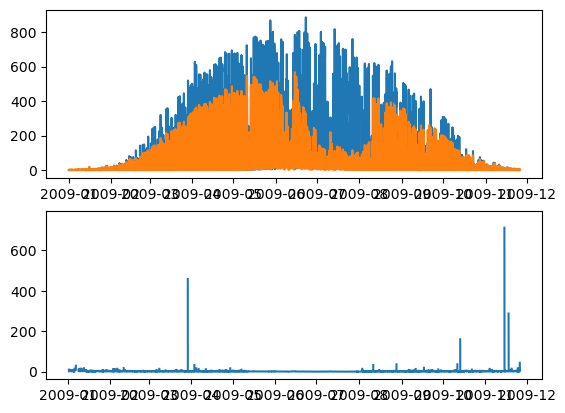

In [257]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(jjmc_save["2009"][["CM3 up Cal", "CM3 Down Cal"]])

ax2 = fig.add_subplot(2,1,2)
ax2.plot(jjmc_save["2009"]["CM3 Down Cal"] / jjmc_save["2009"]["CM3 up Cal"])

### save data 
save the processed data as input datafile for Cosipy
- only one header line
- na_values as NAN

In [255]:
target_directory = r'C:\Users\leopo\Master\Thesis\data\data_shaped'
filename_jjmc = r'\jjmc_cosipy.csv'
#filename_jjmcfoehn = r'\jjmc_foehn_cosipy.csv'
#filename_jjmcnofoehn = r'\jjmc_nofoehn_cosipy.csv'

jjmc_save.to_csv(target_directory+filename_jjmc, na_rep = 'NAN')
#jjmc_foehn.to_csv(target_directory+filename_jjmcfoehn, na_rep = 'NAN')
#jjmc_nofoehn.to_csv(target_directory+filename_jjmcnofoehn, na_rep = 'NAN')

In [310]:
jjmc.columns

Index(['Unnamed: 0', 'Year', 'Day', 'Time', 'batt volt', 'log temp', 'AT 3m',
       'RH 3m', 'AT 2m', 'RH 2m', 'AT 1m', 'RH 1m', 'FWT', 'FWT Ref',
       '3m Wind (m/s)', '3m Wind dir', '3m Wind dir.1', '3m Wind Max (m/s)',
       '1m Wind (m/s)', '1m Wind Dir', '1 m Wind std', '1m Wind max(m/s)',
       'SR50 raw', 'SR50 cor', 'rain (mm)', 'rain int (mm)', 'rain time',
       'CM3 UP', 'CM3 Down', 'CG3 UP', 'CG3 Down', 'CNR_T_C', 'CNR_T_K',
       'Net Solar', 'Net Long', 'Albedo', 'Up Total', 'Down Total',
       'Net Total', 'CG3 UP Cor', 'CG3 Down Cor', 'FWT 1m', 'FWT 3m',
       'FWT 4.5m', 'FWT 6m', 'CNR1 tilt', 'CNR1 tilt.1', 'CM3 up Cal',
       'CM3 Down Cal', 'CG3 up cal', 'CG3 down cal', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Datetime',
       'pressure (mb)', '2m AT (K)', 'T_diff', 'SW_net', 'snowheight_change',
       'snowfall', 'SWE', 'total precip'],
      dtype='object')

In [141]:
theta_x = 5
theta_y = 1
S_korrigiert = 500 * math.cos(math.radians(theta_x)) * math.cos(math.radians(theta_y))
S_korrigiert

498.0214864070244

In [139]:
import math

# Winkel in Grad
theta_x = 88
theta_y = 89.5

# Umrechnung in Bogenmaß für die math-Module-Funktionen
theta_x_rad = math.radians(theta_x)
theta_y_rad = math.radians(theta_y)

# Neigungswinkel zur x-y-Ebene berechnen
theta_z_rad = math.atan(math.tan(theta_y_rad) / math.tan(theta_x_rad))

# Umrechnung von Bogenmaß in Grad
theta_z_deg = math.degrees(theta_z_rad)

print(f"Der Neigungswinkel zur x-y-Ebene beträgt {theta_z_deg:.2f} Grad.")

Der Neigungswinkel zur x-y-Ebene beträgt 75.97 Grad.


In [136]:
jjmc["CNR1 tilt"].nlargest(50)

utc_time
2014-01-22 04:00:00    100.500
2013-11-11 21:00:00      8.110
2014-05-31 22:00:00      6.255
2011-12-04 17:00:00      5.940
2009-11-05 23:00:00      5.908
2008-12-10 11:00:00      5.871
2013-12-13 04:00:00      5.688
2013-04-21 23:00:00      5.684
2012-09-17 10:00:00      5.181
2009-09-04 20:00:00      5.069
2009-01-17 19:00:00      5.056
2012-09-17 21:00:00      5.029
2011-11-02 07:00:00      4.799
2012-01-18 18:00:00      4.601
2009-01-17 11:00:00      4.459
2011-02-14 20:00:00      4.271
2011-02-26 16:00:00      4.128
2009-10-22 04:00:00      4.104
2011-12-04 23:00:00      4.076
2011-12-27 19:00:00      4.037
2014-04-26 07:00:00      3.964
2012-02-05 17:00:00      3.853
2008-12-10 07:00:00      3.822
2011-12-30 00:00:00      3.813
2011-04-18 06:00:00      3.797
2013-12-31 00:00:00      3.739
2011-12-27 15:00:00      3.702
2012-01-11 23:00:00      3.702
2012-01-11 22:00:00      3.689
2012-10-28 04:00:00      3.607
2012-11-26 22:00:00      3.603
2011-02-15 03:00:00      3.534

In [137]:
jjmc["CNR1 tilt.1"].nlargest(50)

utc_time
2014-01-22 04:00:00    99.700
2013-11-15 08:00:00     2.842
2012-09-23 23:00:00     1.495
2014-02-17 01:00:00     1.205
2013-06-16 20:00:00     1.048
2012-09-17 15:00:00     0.921
2009-10-22 05:00:00     0.859
2014-01-02 06:00:00     0.793
2012-12-24 05:00:00     0.792
2013-11-15 12:00:00     0.686
2013-11-16 08:00:00     0.685
2009-05-11 17:00:00     0.681
2011-12-05 03:00:00     0.661
2014-06-23 03:00:00     0.641
2012-11-20 04:00:00     0.615
2013-11-15 04:00:00     0.612
2008-12-10 11:00:00     0.604
2013-10-17 18:00:00     0.582
2009-09-04 22:00:00     0.566
2013-11-12 00:00:00     0.566
2013-08-22 14:00:00     0.537
2012-09-05 14:00:00     0.514
2009-02-28 11:00:00     0.473
2013-11-10 09:00:00     0.463
2014-05-13 15:00:00     0.460
2008-12-14 12:00:00     0.442
2013-10-27 04:00:00     0.439
2013-11-16 13:00:00     0.428
2014-08-02 16:00:00     0.419
2013-12-20 22:00:00     0.412
2009-05-14 08:00:00     0.398
2013-12-08 18:00:00     0.386
2014-08-02 19:00:00     0.379
2

In [312]:
jjmc.tail()


,Unnamed: 0,Year,Day,Time,batt volt,log temp,AT 3m,RH 3m,AT 2m,RH 2m,...,Unnamed: 55,Datetime,pressure (mb),2m AT (K),T_diff,SW_net,snowheight_change,snowfall,SWE,total precip
utc_time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 04:00:00,-3999,2014,365,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 05:00:00,-3999,2014,365,2100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 06:00:00,-3999,2014,365,2200,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 07:00:00,-3999,2014,365,2300,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 08:00:00,-3999,2014,366,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
import sys
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4 as nc
import time
import dateutil
from itertools import product
import metpy.calc
from metpy.units import units

#np.warnings.filterwarnings('ignore')
import argparse

In [316]:
cs_file = r'C:\Users\leopo\Master\Thesis\data\data_shaped\jjmc_cosipy.csv'

date_parser = lambda x: dateutil.parser.parse(x, ignoretz=True)
df = pd.read_csv(cs_file,
       delimiter=',', index_col=['utc_time'],                                       #MODIFIED
        parse_dates=['utc_time'], na_values='NAN',date_parser=date_parser)    

In [318]:
df.columns

Index(['Unnamed: 0', 'Year', 'Day', 'Time', 'batt volt', 'log temp', 'AT 3m',
       'RH 3m', 'AT 2m', 'RH 2m', 'AT 1m', 'RH 1m', 'FWT', 'FWT Ref',
       '3m Wind (m/s)', '3m Wind dir', '3m Wind dir.1', '3m Wind Max (m/s)',
       '1m Wind (m/s)', '1m Wind Dir', '1 m Wind std', '1m Wind max(m/s)',
       'SR50 raw', 'SR50 cor', 'rain (mm)', 'rain int (mm)', 'rain time',
       'CM3 UP', 'CM3 Down', 'CG3 UP', 'CG3 Down', 'CNR_T_C', 'CNR_T_K',
       'Net Solar', 'Net Long', 'Albedo', 'Up Total', 'Down Total',
       'Net Total', 'CG3 UP Cor', 'CG3 Down Cor', 'FWT 1m', 'FWT 3m',
       'FWT 4.5m', 'FWT 6m', 'CNR1 tilt', 'CNR1 tilt.1', 'CM3 up Cal',
       'CM3 Down Cal', 'CG3 up cal', 'CG3 down cal', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Datetime',
       'pressure (mb)', '2m AT (K)', 'T_diff', 'SW_net', 'snowheight_change',
       'snowfall', 'SWE', 'total precip'],
      dtype='object')